In [ ]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import time

import shutil

import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F
import copy
import scipy.io
import time
np.random.seed(14894)
torch.manual_seed(14894)

## Defining Hyperparameters for Autoencoders

In [ ]:
hyper_params_ENCODER={'input_size':1,'hidden_size':70,'num_layer':1,'encoded_size':3}

hyper_params_DECODER={'encoded_size':3,'hidden_size':70,'num_layer':1,'decoded_size':1}

device = torch.device('cuda')

print(device)

print_freq = 400


trainer_info = {'epochs': 300,
                'train_size': 4501,
                'train_batch': 16,
                'test_batch': 1024,
                'lr0': 0.6e-3,
                'lr_decay': 0.7}


note = 'LSTM_Spatial_Encoder'
model_name = 'model' + '_' + str(trainer_info['train_size']) + 'train_' + str(hyper_params_ENCODER['num_layer']) + 'layer_' + str(hyper_params_DECODER['hidden_size']) + 'hid_' + str(trainer_info['epochs']) + 'ep_' + note



cuda


## Main class 

In [ ]:
class LSTM_encoder(torch.nn.Module):

    def __init__(self,hyper_params_ENCODER):
        super().__init__()
        input_size = hyper_params_ENCODER['input_size']
        self.hidden_size = hyper_params_ENCODER['hidden_size']
        self.num_layers = hyper_params_ENCODER['num_layer']
        self.reduced_size = hyper_params_ENCODER['encoded_size']
        self.leakrelu = torch.nn.LeakyReLU()
        self.tanh=torch.nn.Tanh()
        self.LSTM = torch.nn.LSTM(input_size, self.hidden_size, self.num_layers,bidirectional=False, batch_first=True)
        self.fc1 = torch.nn.Linear(self.hidden_size, self.reduced_size)
       

    def forward(self, x):
        a0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        
        '''a0=torch.randn((self.num_layers, x.shape[0], self.hidden_size), dtype=torch.float).to(device)
        c0=torch.randn((self.num_layers, x.shape[0], self.hidden_size), dtype=torch.float).to(device)'''
            
        out, (a,c) = self.LSTM(x, (a0,c0))
        
        '''out,a = self.LSTM(x, a0)
        c=a'''

        out = self.leakrelu(out)
        out = self.fc1(out)
        #out=self.tanh(out)
   
        return out,x,(a,c)

class LSTM_decoder(torch.nn.Module):

    def __init__(self,hyper_params_DECODED,coord):
        super().__init__()

        self.reduced_size = hyper_params_DECODED['encoded_size']
        self.hidden_size = hyper_params_DECODED['hidden_size']
        self.num_layers = hyper_params_DECODED['num_layer']
        self.input_size = hyper_params_DECODED['decoded_size']
        self.coord=coord

        self.leakrelu = torch.nn.LeakyReLU()
        self.tanh= torch.nn.Tanh()
        self.LSTM = torch.nn.LSTM(self.reduced_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc1 = torch.nn.Linear(self.hidden_size, self.input_size)
        

    '''def forward(self, a0_init,x,aa0,cc0):

    # a0_init = self.fc1(a00)
    #a0 = torch.zeros(self.num_layers, a0_init.shape[0], self.hidden_size).to(device)
    #c0 = torch.zeros(self.num_layers, a0_init.shape[0], self.hidden_size).to(device) # My method

    a0 = torch.zeros(self.num_layers, a0_init.shape[0], self.reduced_size).to(device)


    #print(a0_init.shape)
    a0[0, :, :] = a0_init.clone()
    aug_a = a0_init.repeat(1, x.shape[1]).reshape(a0_init.shape[0],

                                           x.shape[1], a0_init.shape[1])

    #c0[0, :, :] = a0_init.clone()  # My moethod


    #print(aug_a.shape)
    #print(samples[:,:,0].shape)

    coord1=self.coord.repeat(x.shape[0],1)

    aug_a1=torch.cat((aug_a,(coord1).unsqueeze(2).to(device).float()),dim=2)
    # inp = torch.cat(aug_a, axis=2)
    out, (a,c) = self.LSTM(aug_a1, (aa0,cc0))
    out = self.leakrelu(out)
    out = self.fc1(out)
    return out'''
        
    def forward(self, a0_init,x):

    # a0_init = self.fc1(a00)
        a0 = torch.zeros(self.num_layers, a0_init.shape[0], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, a0_init.shape[0], self.hidden_size).to(device)



        #print(a0_init.shape)
        #a0[:, :, :] = a0_init.repeat(a0.shape[0],1,1).clone()
        aug_a = a0_init.repeat(1, x.shape[1]).reshape(a0_init.shape[0],

                                               x.shape[1], a0_init.shape[1])

        #c0[:, :, :] = a0_init.repeat(a0.shape[0],1,1).clone()


        #print(aug_a.shape)
        #print(samples[:,:,0].shape)

        #coord1=self.coord.repeat(x.shape[0],1)

        #aug_a1=torch.cat((aug_a,(coord1).unsqueeze(2).to(device).float()),dim=2)
        # inp = torch.cat(aug_a, axis=2)
        out, (a,c) = self.LSTM(aug_a, (a0,c0))
        
        #out,a = self.LSTM(aug_a1,a0)
        out = self.leakrelu(out)
        
        out = self.fc1(out)
        #out = self.tanh(out)
        return out


class LSTM_encoder_decoder(torch.nn.Module):

    def __init__(self,hyper_params_ENCODER,hyper_params_DECODER,coord):
        super().__init__()

        self.encoder = LSTM_encoder(hyper_params_ENCODER)
        self.decoder = LSTM_decoder(hyper_params_DECODER,coord)
        self.coord=coord
        
        self.init_weights()

    def init_weights(self):
        with torch.set_grad_enabled(True):
            
            for name, param in self.named_parameters():
                print(f"Initializing parameter '{name}' with shape: {param.shape}")
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                    #nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.constant_(param, 0.0)

    def forward(self, inp_encoder):
        with torch.set_grad_enabled(True):
            y_code,x,(a,c) = self.encoder(inp_encoder)
            #print(y_code[:, y_code.shape[1] - 1].shape)
            y_recovered = self.decoder(y_code[:, y_code.shape[1]-1],x)
            return y_recovered,y_code[:, y_code.shape[1] - 1]

## Defining Utility Functions and Training Functions

In [ ]:
class MinMax_Scaler(object):

    def __init__(self, data, keep_data=False):
        self.min = np.min(data, axis=(0, 1), keepdims=True)
        self.max = np.max(data, axis=(0, 1), keepdims=True)

        if keep_data is True:
            self.data = self.transform(data, tensor=False)
        else:
            self.data = []

    def transform(self, data, tensor_format=False):
        if tensor_format is False:
            data = (data - self.min) / (self.max - self.min)
        else:
            min_tensor = torch.tensor(self.min).to(device)
            max_tensor = torch.tensor(self.max).to(device)
            for c in range(data.shape[2]):
                data[:, :, c] = torch.div(torch.sub(data[:, :, c], min_tensor[0, 0, c]), torch.sub(max_tensor[0, 0, c], min_tensor[0, 0, c]))
        return data

    def inv_transform(self, data, tensor_format=False):
        if tensor_format is False:
            data = data * (self.max - self.min) + self.min
        else:
            min_tensor = torch.tensor(self.min).to(device)
            max_tensor = torch.tensor(self.max).to(device)
            for c in range(data.shape[2]):
                data[:, :, c] = torch.add(torch.mul(data[:, :, c], torch.sub(max_tensor[0, 0, c], min_tensor[0, 0, c])), min_tensor[0, 0, c])
        return data

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, strain, stress):
        self.strain = strain
        self.stress = stress

    def __len__(self):
        return self.strain.shape[0]

    def __getitem__(self, index):
        return self.strain[index], self.stress[index]


class AverageMeter(object):
    # Computes and stores the average and current value

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def customized_loss(output, target):

    mse = torch.nn.MSELoss()

    output1 = output[:, :, 0:3]
    output2 = output[:, :, 3:6]

    target1 = target[:, :, 0:3]
    target2 = target[:, :, 3:6]

    return 0.5 * torch.maximum(mse(output1, target1), mse(output2, target2))

def train_step(train_loader, model, criterion, optimizer, epoch, net_info):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.to(device)
        target = target.to(device)

        # compute output
        output,enc = model(input)
    
        loss = criterion(output, target)
        
        #print(enc)
        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # compute gradient and do the SGD step
        optimizer.zero_grad()
        loss.backward()
        
        '''for name, param in model.named_parameters():
            if param.grad is not None:
                print(f"Gradient for parameter '{name}':\n{param.grad}")
            else:
                print(f"No gradient for parameter '{name}'")'''

        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 25 == 0:
            if i % print_freq == 0:
                curr_lr = optimizer.param_groups[0]['lr']
                print('Epoch: [{0}/{1}][{2}/{3}]\t'
                    'LR: {4}\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.6f})\t'.format(
                    epoch, net_info['epochs'], i, len(train_loader), curr_lr,
                    batch_time=batch_time, data_time=data_time, loss=losses))
    return losses.avg


def test_step(test_loader, model, criterion, epoch):
    batch_time = AverageMeter()
    losses = AverageMeter()
    # violation = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(test_loader):

        input = input.to(device)
        target = target.to(device)

        # compute output
        output,_ = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        losses.update(loss.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if epoch % 25 == 0:
            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.7f} ({loss.avg:.4f})\t'.format(
                    i, len(test_loader), batch_time=batch_time, loss=losses))

    return losses.avg

#@title train_RNN()
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        #shutil.copyfile(filename, 'model_best_LSTM_Spatial_Salinity_AC_interpol_(1500-3000)_(7500-8500).pth.tar')
        shutil.copyfile(filename, 'Salinity_AC(1500-3000).pth.tar')


def train_LSTM_autoencoder(model, net_info, train_loader, test_loader,hyper_params_ENCODER, hyper_params_DECODER):

    epochs = net_info['epochs']
    train_losses = np.empty([epochs, 1])
    test_losses = np.empty([epochs, 1])

    min_loss = 1e4

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=net_info['lr0'],weight_decay=1e-7)

    for epoch in range(epochs):
        # adjust learning rate
        if epoch >= 24:
            if epoch % 24== 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= net_info['lr_decay']

        # train for one epoch
        train_losses_temp = train_step(train_loader, model, criterion, optimizer, epoch, net_info)
        train_losses[epoch] = train_losses_temp

        # evaluate on test set
        test_losses_temp = test_step(test_loader, model, criterion, epoch)
        test_losses[epoch] = test_losses_temp

        # remember best MSE and save checkpoint
        is_best = test_losses[epoch] < min_loss
        min_loss = min(test_losses[epoch], min_loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'min_loss': min_loss,
            'optimizer': optimizer.state_dict(),
        }, is_best)

    test_losses.tofile('test_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")
    train_losses.tofile('train_loss' + str(net_info['train_size']) + '2l50h.csv', sep=",", format="%10.5f")

    plt.figure(figsize=(10, 7))
    plt.plot(train_losses, label='training')
    plt.plot(test_losses, '--', label='test')
    plt.xlabel('epoch')
    plt.ylabel('MSE')
    plt.title('Training and Test Loss\n(hidden size=%s, num layers=%s model'%(hyper_params_ENCODER['hidden_size'],hyper_params_ENCODER['num_layer']))
    plt.yscale('log')
    plt.legend()
    plt.show()
    return model

#@title main_program()
def main_program(T_S, T_S_out,val_T_S, val_T_S_out,hyper_params_ENCODER, hyper_params_DECODER, model,trainer_info, model_name):
    num_sample = trainer_info['train_size']
    T_S_train = T_S[:, :, :]
    T_S_out_train = T_S_out[:, :, :]
    training_set = MyDataset(T_S_train, T_S_out_train)

    T_S_test = val_T_S[:, :, :]
    T_S_out_test = val_T_S_out[:, :, :]
    val_set = MyDataset(T_S_test, T_S_out_test)

    # create training/test loaders
    train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                               batch_size=trainer_info['train_batch'],
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=val_set,
                                              batch_size=trainer_info['test_batch'],
                                              shuffle=True)

    model = train_LSTM_autoencoder(model, trainer_info, train_loader, test_loader,hyper_params_ENCODER, hyper_params_DECODER)
    torch.save(model.state_dict(), model_name)

    return model



## Loading Datasets

In [ ]:
import copy

data=loadmat("Input_ROM")
coordinates=pd.read_excel("coordinates.xlsx",header=None)
coord=coordinates.iloc[:].values.reshape(-1,1)
Input=data['TT'].astype(np.float32)
UN_Input = copy.deepcopy(Input)
ZZ=copy.deepcopy(coord.T)
from scipy.interpolate import griddata
points=ZZ[0]
no_of_points=50
xi=np.linspace(-110,-0.15,no_of_points)

Input_inter=np.zeros((Input.shape[0],no_of_points,1))
for i in range(Input.shape[0]): 
    Input_inter[i,:,:]=griddata(points,Input[i,:,1:2],xi,method='cubic')
    
Input=Input_inter.astype(np.float32)

Input1=Input[0:1500,:,0:1]

Input2=Input[3300:4500,:,0:1]


# Adding the final break phase period(7500-8500)
Input3=Input[7500:8500,:,0:1]




Valx=Input[3000:3300,:,0:1].astype(np.float32)

x=np.concatenate([Input1,Input2,Input3],axis=0).astype(np.float32)


In=MinMax_Scaler(x)
x_tr=In.transform(x)
Valx_tr=In.transform(Valx)



#coord=coord[::6]




cord=MinMaxScaler()

coord=cord.fit_transform(coord)

coord=torch.from_numpy(coord).reshape(1,-1).float().to(device)

time=loadmat("Input_BC")
time=time['BC'].astype(np.float32)[:,0]

hours=time/(3600)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f518db97c10>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Initializing parameter 'encoder.LSTM.weight_ih_l0' with shape: torch.Size([280, 1])
Initializing parameter 'encoder.LSTM.weight_hh_l0' with shape: torch.Size([280, 70])
Initializing parameter 'encoder.LSTM.bias_ih_l0' with shape: torch.Size([280])
Initializing parameter 'encoder.LSTM.bias_hh_l0' with shape: torch.Size([280])
Initializing parameter 'encoder.fc1.weight' with shape: torch.Size([3, 70])
Initializing parameter 'encoder.fc1.bias' with shape: torch.Size([3])
Initializing parameter 'decoder.LSTM.weight_ih_l0' with shape: torch.Size([280, 3])
Initializing parameter 'decoder.LSTM.weight_hh_l0' with shape: torch.Size([280, 70])
Initializing parameter 'decoder.LSTM.bias_ih_l0' with shape: torch.Size([280])
Initializing parameter 'decoder.LSTM.bias_hh_l0' with shape: torch.Size([280])
Initializing parameter 'decoder.fc1.weight' with shape: torch.Size([1, 70])
Initializing parameter 'decoder.fc1.bias' with shape: torch.Size([1])
Epoch: [0/300][0/232]	LR: 0.0006	Time 0.374 (0.374)	Da

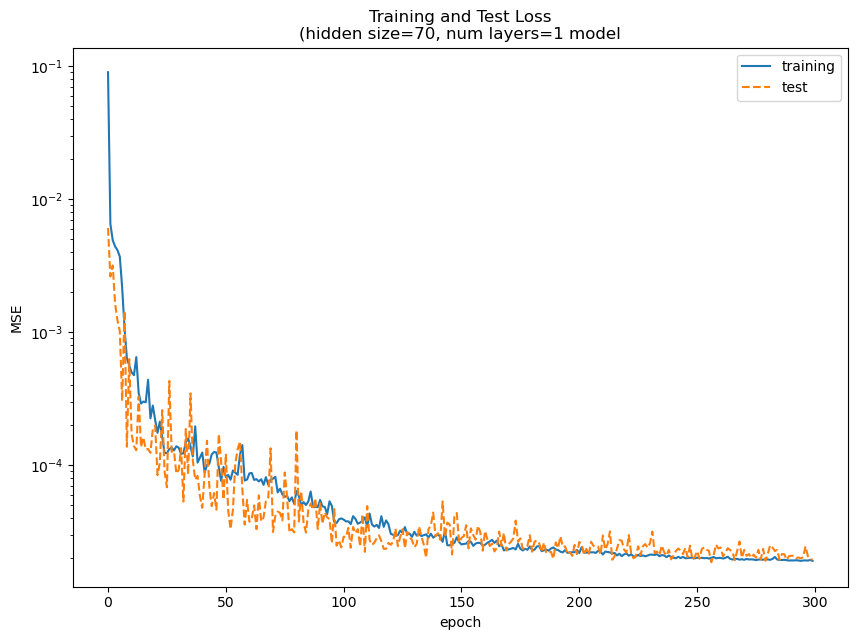

Total execution time: 207.54831790924072 seconds


In [ ]:
import time

start_time = time.time()
model=LSTM_encoder_decoder(hyper_params_ENCODER, hyper_params_DECODER,coord).to(device)
model = main_program(x_tr, x_tr,Valx_tr,Valx_tr,hyper_params_ENCODER, hyper_params_DECODER,model, trainer_info, model_name)
end_time = time.time()

# Calculate and print the total execution time
total_execution_time = end_time - start_time
print(f"Total execution time: {total_execution_time} seconds")

## Load Trained model

In [ ]:
# Predicting 1500-8500 while using active phase period as usual and a bit of final period of break phase

best_model_params = torch.load('model_best_LSTM_Spatial_Salinity_AC_interpol_(1500-3000)_(7500-8500).pth.tar', map_location=device)['state_dict']

In [ ]:
model=LSTM_encoder_decoder(hyper_params_ENCODER, hyper_params_DECODER,coord).to(device)
model.load_state_dict(best_model_params)

Initializing parameter 'encoder.LSTM.weight_ih_l0' with shape: torch.Size([280, 1])
Initializing parameter 'encoder.LSTM.weight_hh_l0' with shape: torch.Size([280, 70])
Initializing parameter 'encoder.LSTM.bias_ih_l0' with shape: torch.Size([280])
Initializing parameter 'encoder.LSTM.bias_hh_l0' with shape: torch.Size([280])
Initializing parameter 'encoder.fc1.weight' with shape: torch.Size([3, 70])
Initializing parameter 'encoder.fc1.bias' with shape: torch.Size([3])
Initializing parameter 'decoder.LSTM.weight_ih_l0' with shape: torch.Size([280, 3])
Initializing parameter 'decoder.LSTM.weight_hh_l0' with shape: torch.Size([280, 70])
Initializing parameter 'decoder.LSTM.bias_ih_l0' with shape: torch.Size([280])
Initializing parameter 'decoder.LSTM.bias_hh_l0' with shape: torch.Size([280])
Initializing parameter 'decoder.fc1.weight' with shape: torch.Size([1, 70])
Initializing parameter 'decoder.fc1.bias' with shape: torch.Size([1])


<All keys matched successfully>

In [ ]:
time_step=10
time_step_test=10
encoded_size=3

## Vaildating against validation set

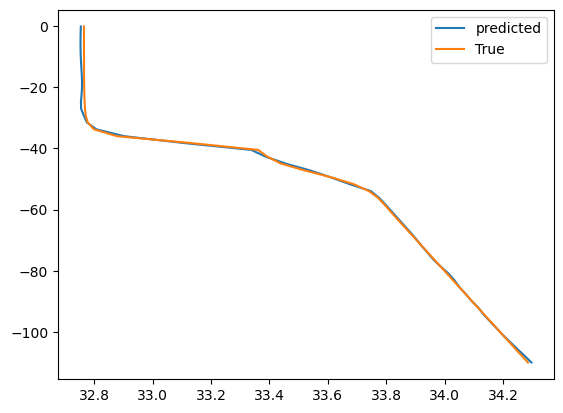

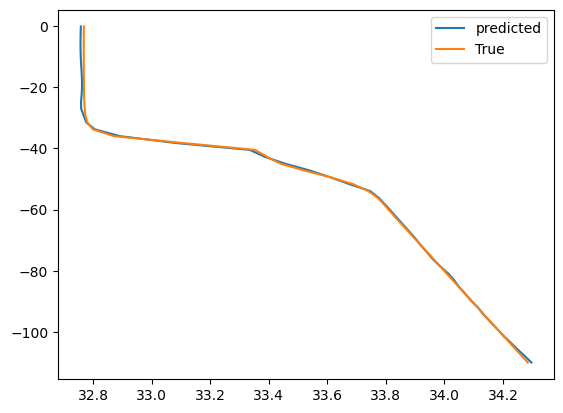

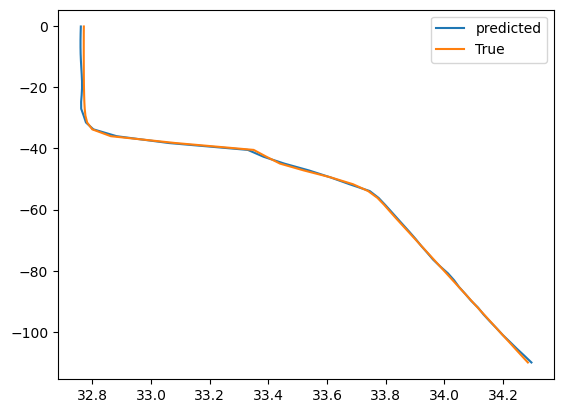

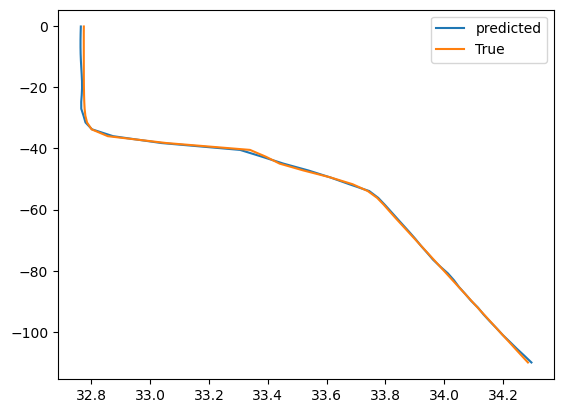

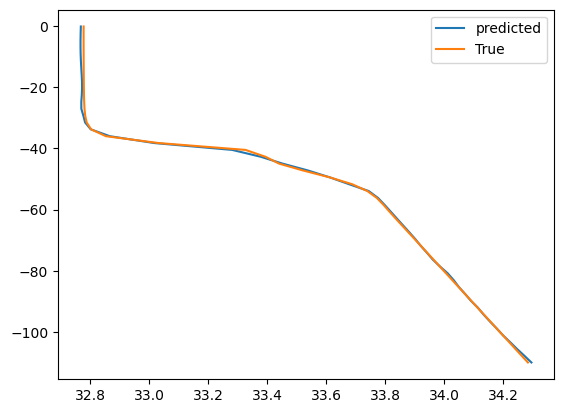

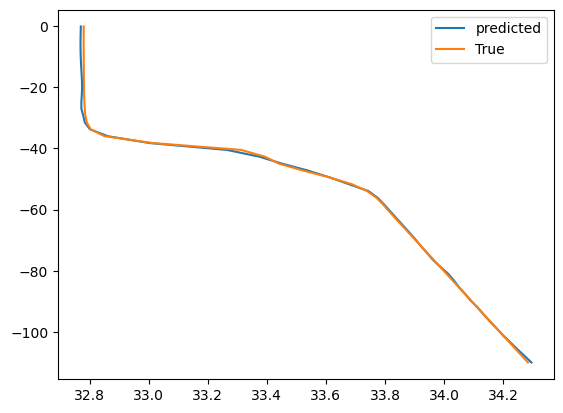

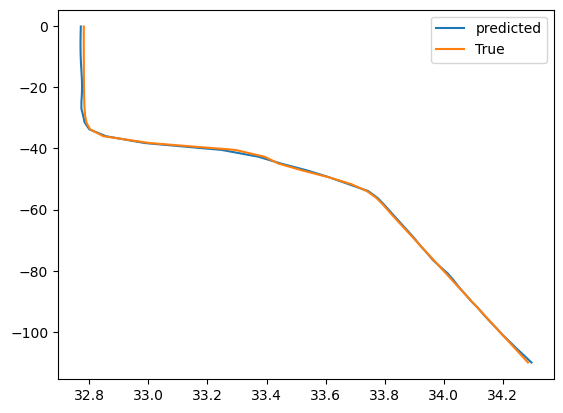

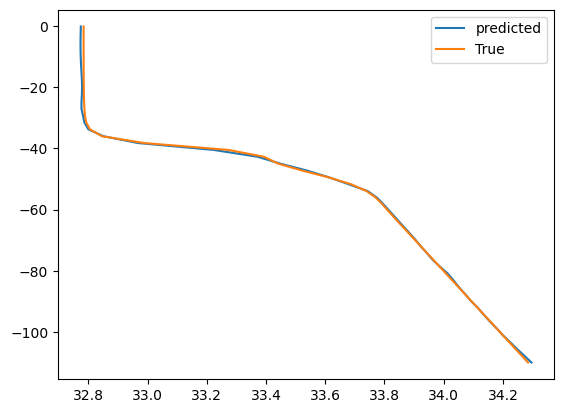

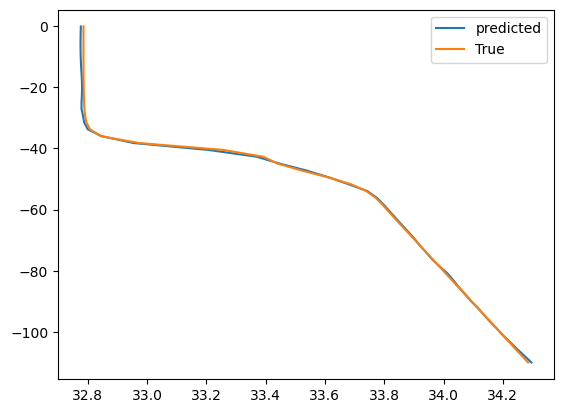

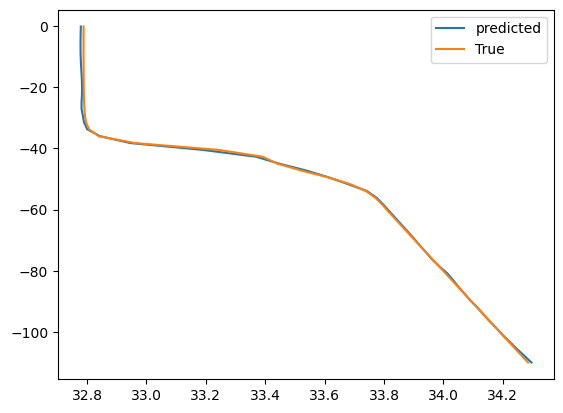

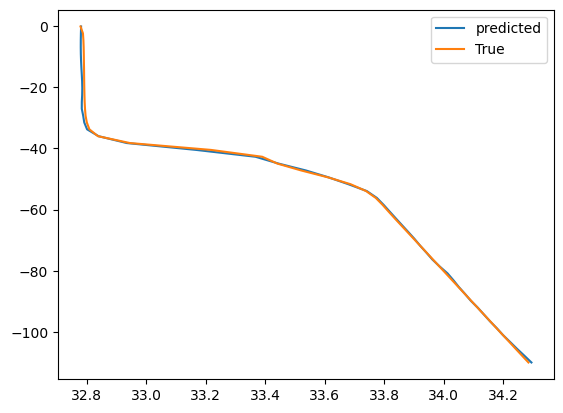

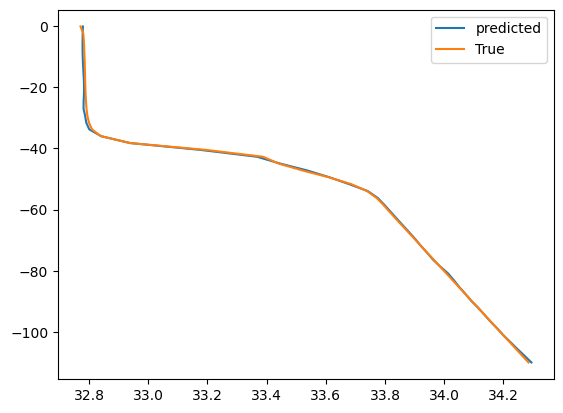

In [ ]:
x_rec=torch.zeros((Valx_tr.shape[0],Valx_tr.shape[1],Valx_tr.shape[2]))
j=0
for i in range(Valx_tr.shape[0]):
    
    x_rec[i,:,:],_=model((torch.tensor(Valx_tr[i:i+1,:,:]).to(device)))
    if i%25==0:
        plt.figure(i)
        plt.plot(In.inv_transform(x_rec[i:i+1,:,:].detach().numpy())[:,:,0].T,xi.T,label='predicted')
        plt.plot(In.inv_transform(Valx_tr[i:i+1,:,:])[:,:,0].T,xi.T,label='True')
        plt.legend()
    j=j+1

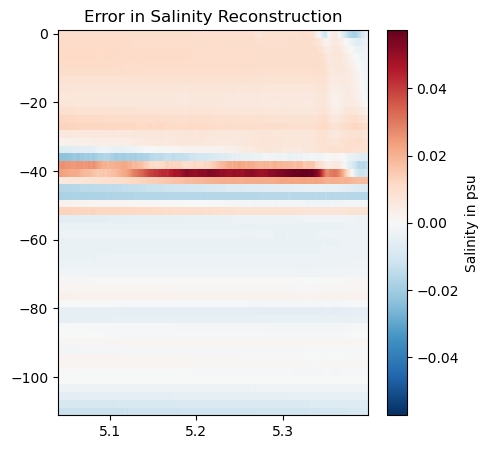

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import Normalize

[xx, tt] = np.meshgrid(xi.flatten(), hours[3000:3300]/24)

data = In.inv_transform(Valx_tr[:,:,:])[:,:,0]-In.inv_transform(x_rec[:,:,:].cpu().detach().numpy())[:,:,0]
max_val = np.max(np.abs(data))

#norm = TwoSlopeNorm(vmin=np.min(In.inv_transform(Valx_tr[:,:,:])[:,:,0]-In.inv_transform(x_rec[:,:,:].cpu().detach().numpy())[:,:,0]), vcenter=0, vmax=np.max(In.inv_transform(Valx_tr[:,:,:])[:,:,0]-In.inv_transform(x_rec[:,:,:].cpu().detach().numpy())[:,:,0]))

norm = Normalize(vmin=-max_val, vmax=max_val)
im = ax.pcolormesh(
    tt, xx, data, 
    label='predicted', norm=norm, cmap="RdBu_r"
)


#im=ax.pcolormesh(tt,xx,In.inv_transform(Testx_tr[time_step:,:,:])[:,:,0]-In.inv_transform(x_rec[time_step:,:,:].cpu().detach().numpy())[:,:,0],label='predicted')
ax.set_title('Error in Salinity Reconstruction')

colo=plt.colorbar(im, ax=ax)
colo.set_label('Salinity in psu')
plt.show()

## Begin Testing the autoencoder

In [ ]:
Testx=Input[1500-time_step_test:7500,:,0:1] ## C
Testx_tr=In.transform(Testx)
#Testx_tr=torch.from_numpy(Text_tr).float().to(device)
print(Testx_tr.shape)
endtime=7500

(6010, 50, 1)


In [ ]:
x_rec=torch.zeros((Testx_tr.shape[0],x_tr.shape[1],x_tr.shape[2]))
j=0
for i in range(Testx_tr.shape[0]):
    
    x_rec[i,:,:],_=model((torch.tensor(Testx_tr[i:i+1,:,:]).to(device)))
    if i%25==0:
        '''plt.figure(i)
        plt.plot(In.inv_transform(x_rec[i:i+1,:,:].detach().numpy())[:,:,0].T,xi,label='predicted')
        plt.plot(In.inv_transform(Testx_tr[i:i+1,:,:])[:,:,0].T,xi,label='True')
        plt.legend()'''
    j=j+1

In [ ]:
x_rec1=np.zeros((x_rec.shape[0],240,1))
Testx_tr1=np.zeros((Testx_tr.shape[0],240,1))

for i in range(Testx_tr.shape[0]): 
    x_rec1[i,:,:]=griddata(xi,x_rec[i,:,0:1].cpu().detach().numpy(),points,method='cubic')
    Testx_tr1[i,:,:]=griddata(xi,Testx_tr[i,:,0:1],points,method='cubic')
    
print(x_rec1.shape)
print(Testx_tr1.shape)

x_rec1=torch.from_numpy(x_rec1)

(6010, 240, 1)
(6010, 240, 1)


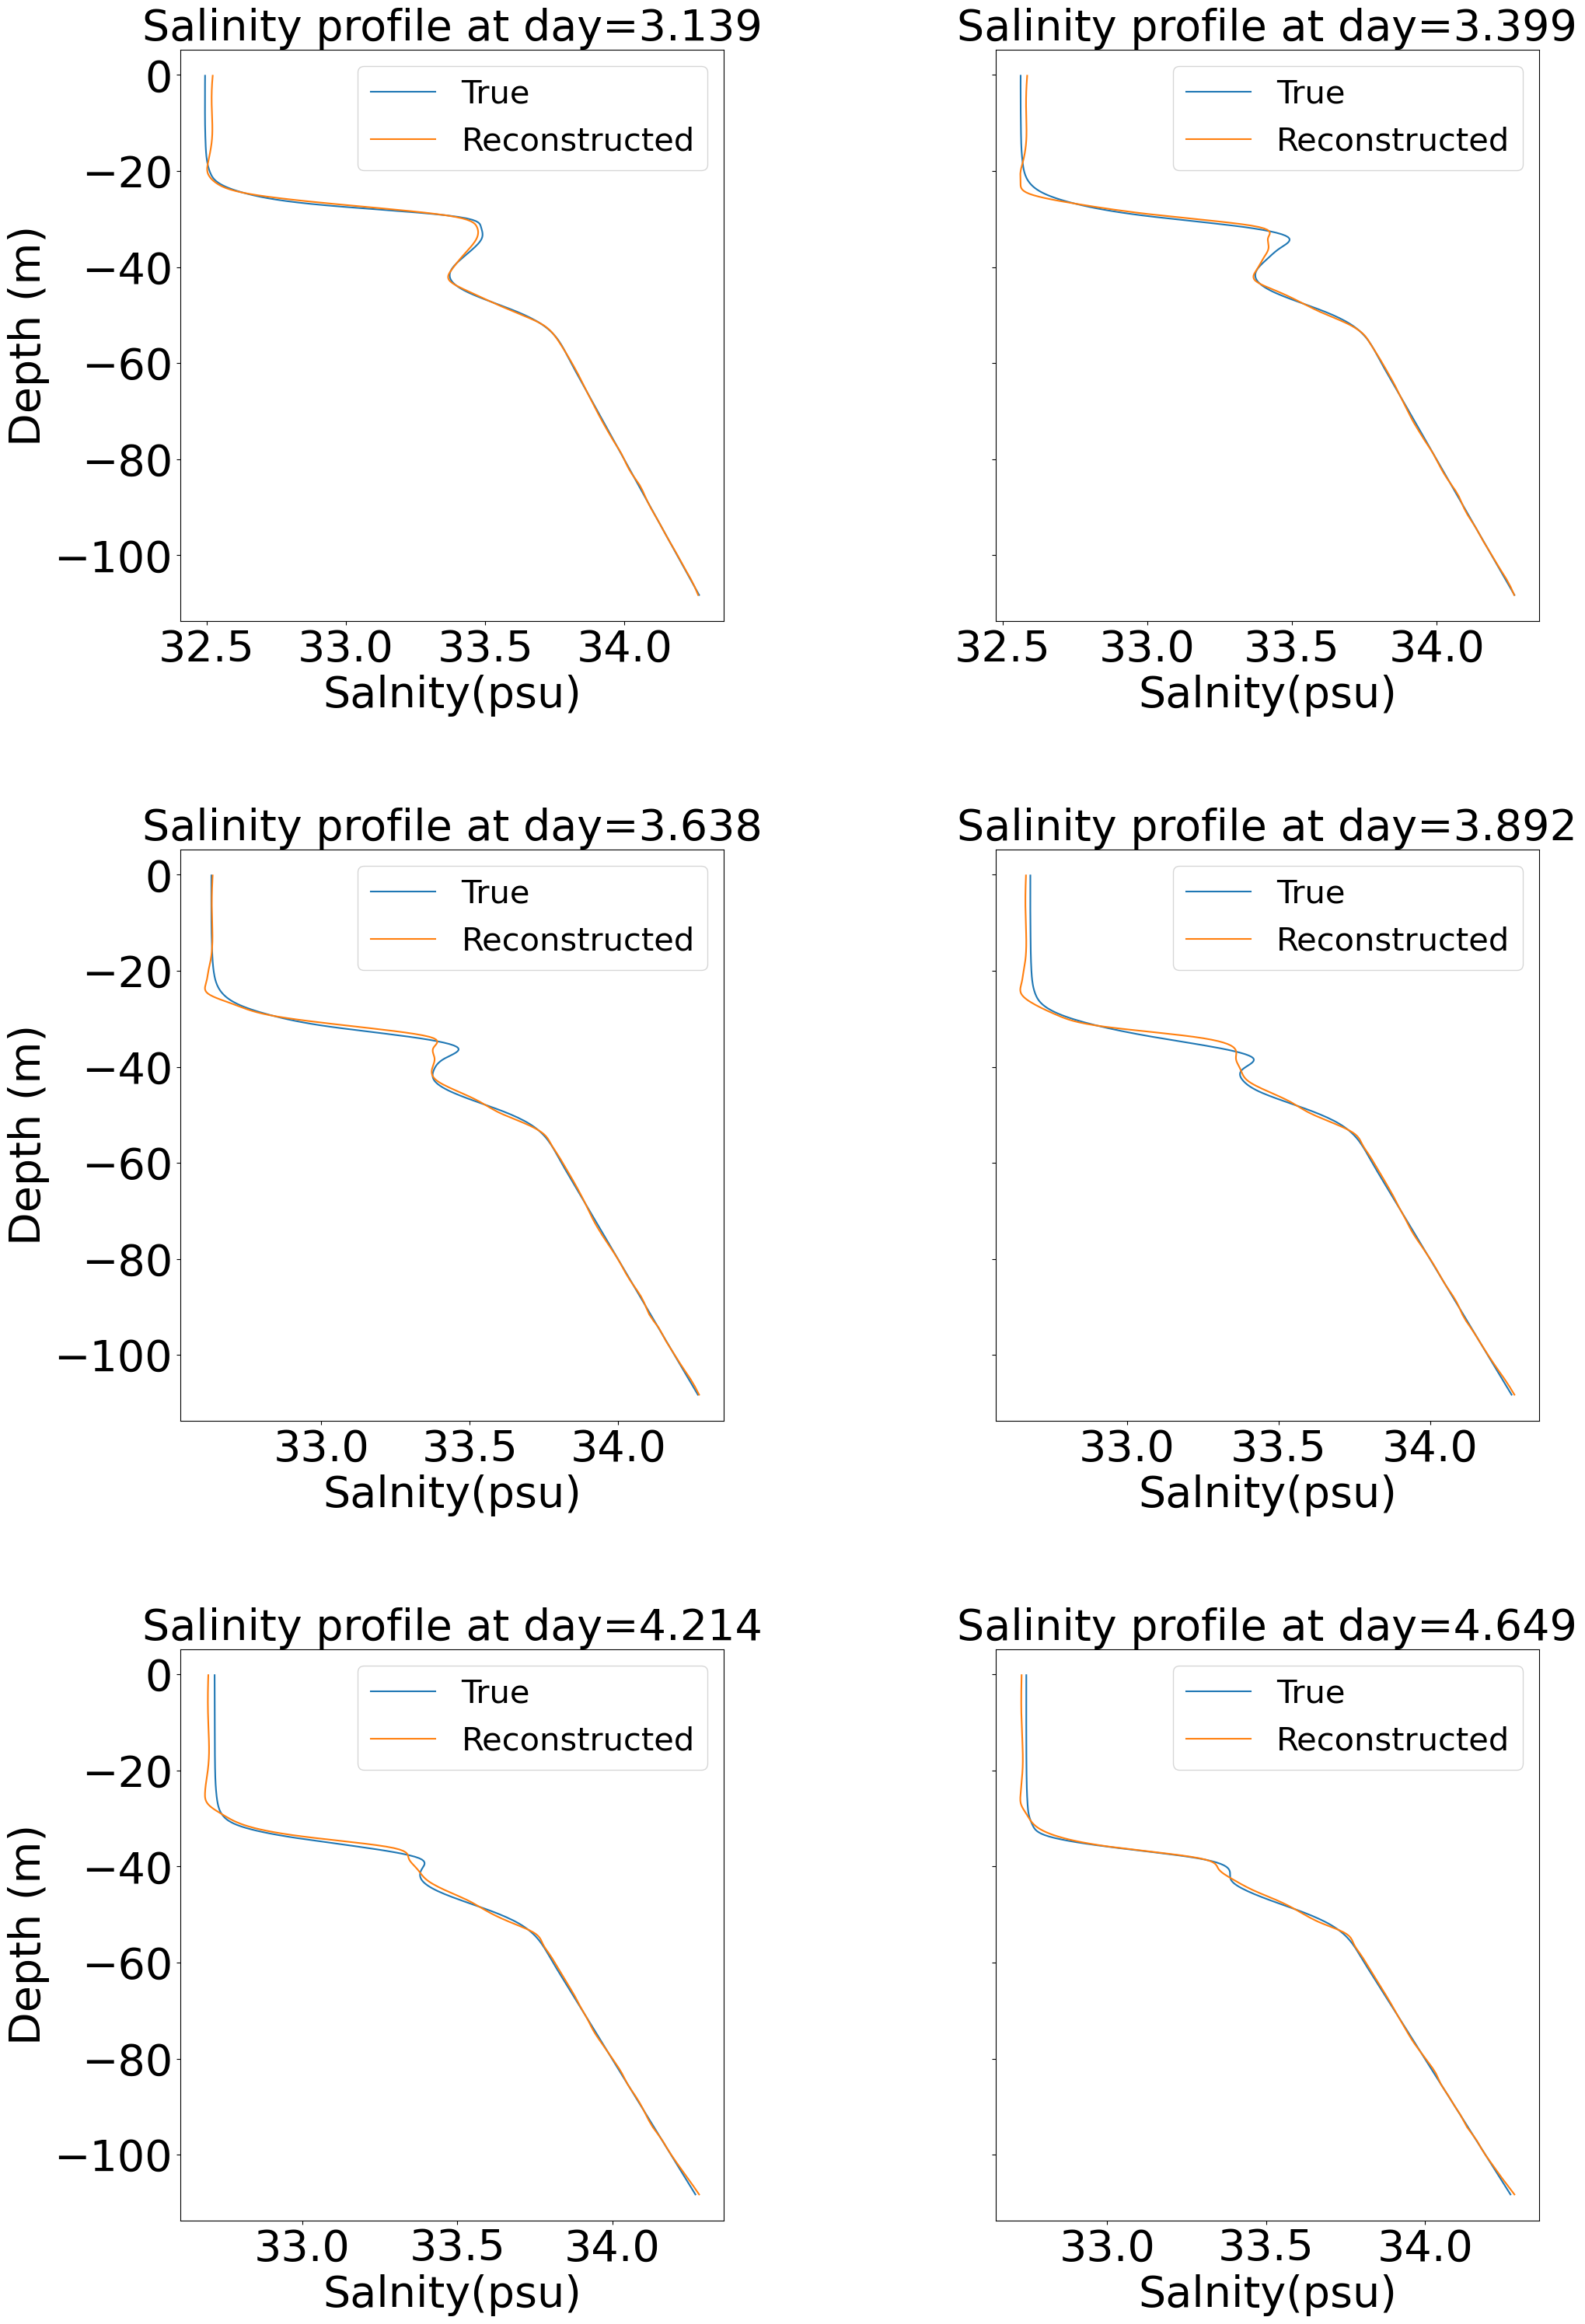

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(20,30),sharey=True,squeeze=True)
days=hours/24
p = 0
timeSteps=p+1500
for i in range(3):
    for j in range(2):
        ax[i, j].plot(In.inv_transform(Testx_tr1[p,:,:])[:,:,0].T,ZZ.T,label='True')
        ax[i, j].plot(In.inv_transform(x_rec1[p,:,:].detach().numpy())[:,:,0].T,ZZ.T,label='predicted')
        if j==0:
            ax[i, j].set_ylabel('Depth (m)',fontsize=40)
        ax[i, j].legend(['True','Reconstructed'], fontsize=30)
        ax[i, j].set_title(f'Salinity profile at day=%1.3f' % days[timeSteps], fontsize=40)
        ax[i,j].tick_params(axis='both', labelsize=40)
        ax[i, j].set_xlabel('Salnity(psu)',fontsize=40)

        p += 250 ## 1166 for 1500-7500 and 1500-8500 250 for 1500-3000
        timeSteps += 250 ##1166 "  " 

plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.4)
plt.show()

'print(In.inv_transform(x_rec.detach().numpy())[:,-1,0])\nprint((x)[:,-1,0])'

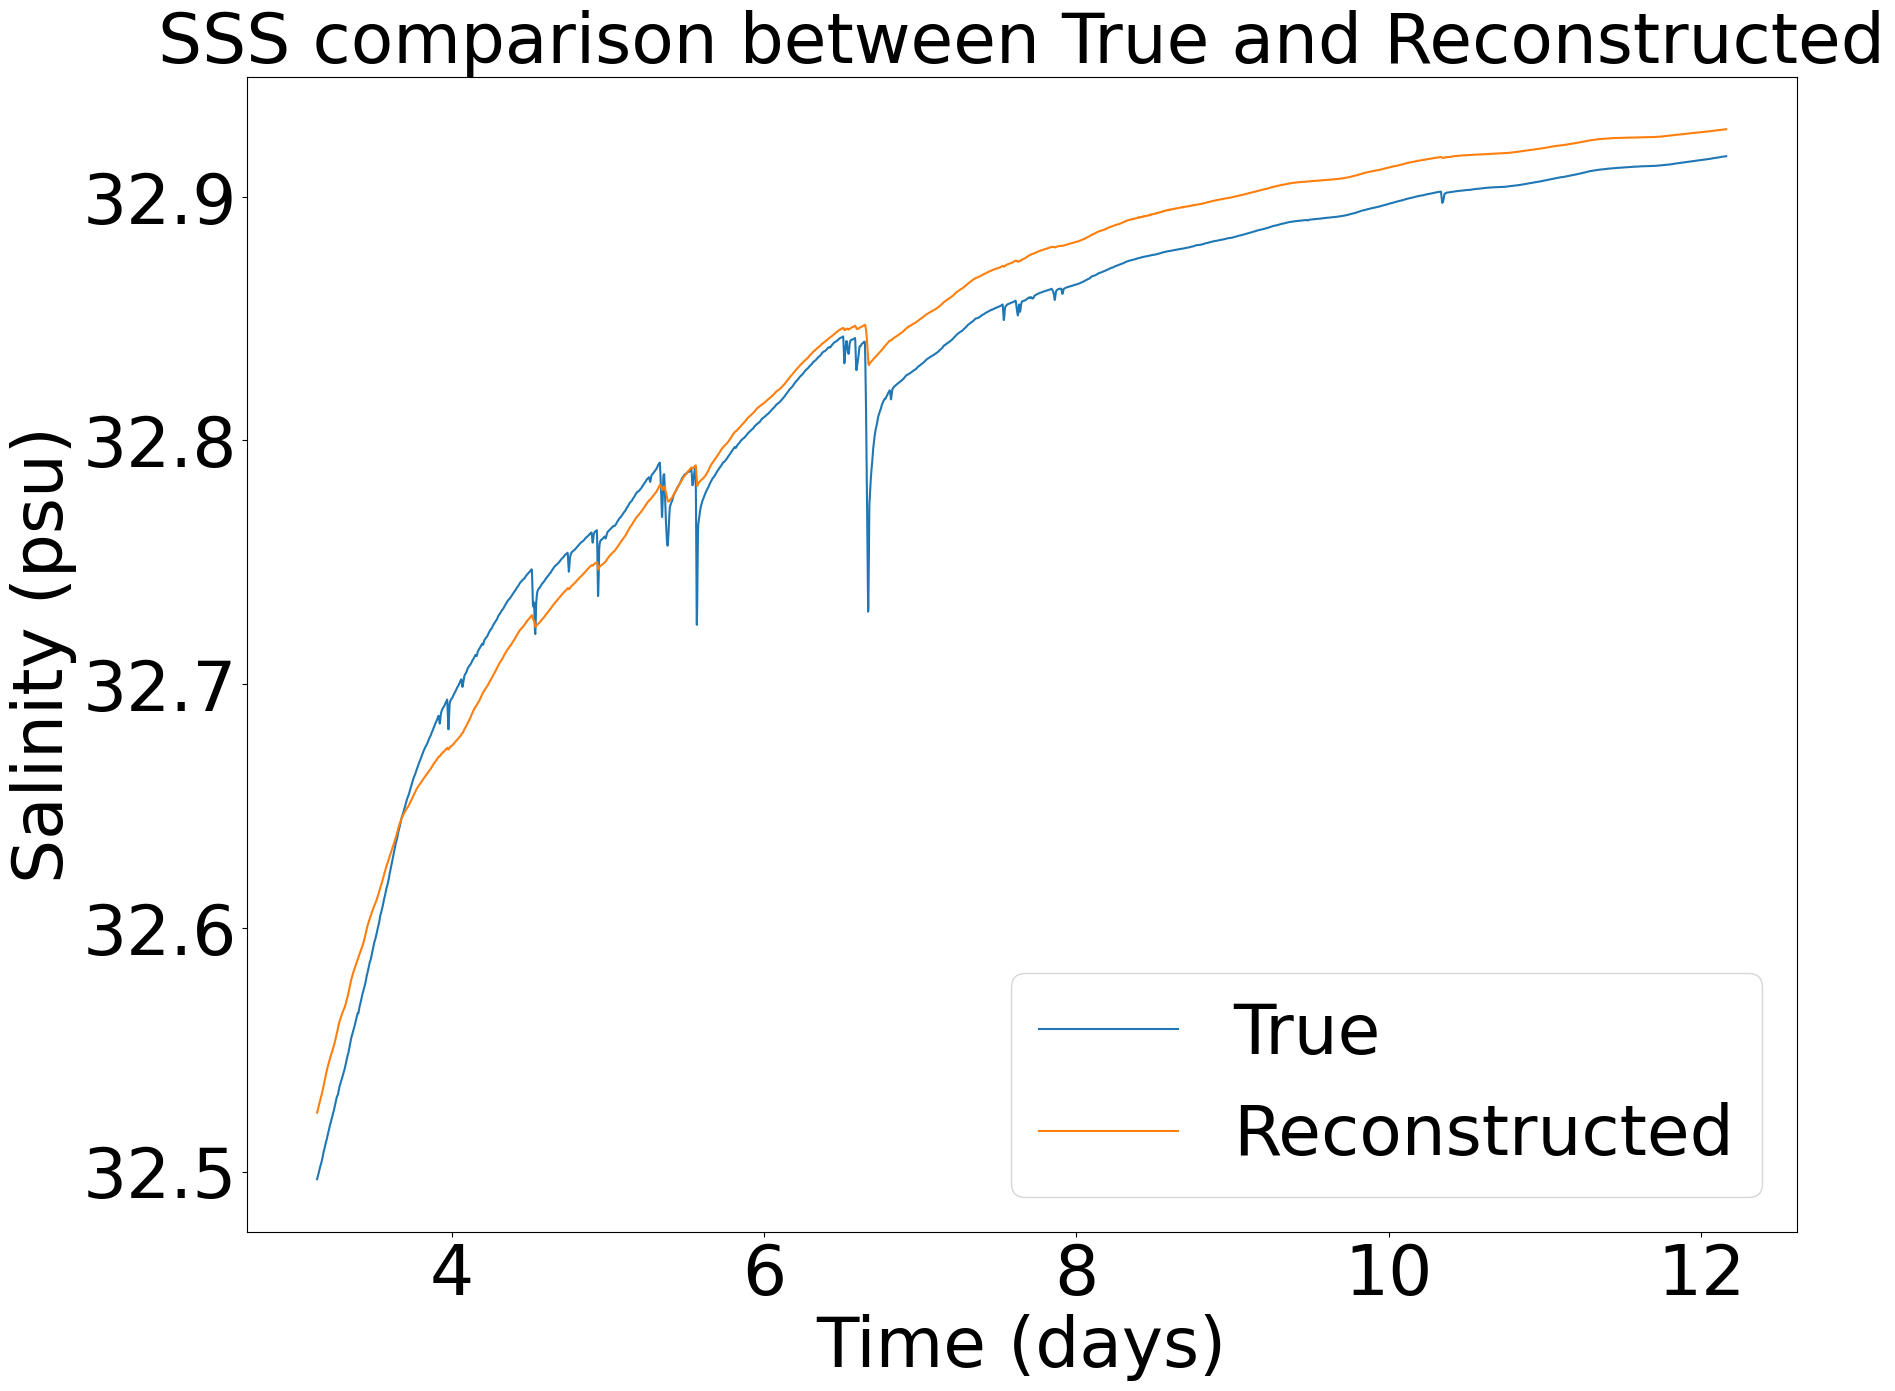

In [ ]:
fig,ax= plt.subplots(1,1,figsize=(20,15))
t=np.linspace(7000,8501,1501,endpoint=False)
ax.plot(hours[1500:endtime]/24,In.inv_transform(Testx_tr1)[time_step:,-1,0],label='True')
ax.plot(hours[1500:endtime]/24,In.inv_transform(x_rec1.detach().numpy())[time_step:,-1,0],label='Reconstructed')

ax.set_xlabel('Time (days)',fontsize=50)
ax.set_ylabel('Salinity (psu)',fontsize=50)
ax.set_title('SSS comparison between True and Reconstructed',fontsize=50)
ax.legend(fontsize=50)
ax.tick_params(axis='both', labelsize=50)
'''ax[1].plot(In.inv_transform(x_rec.detach().numpy())[:,-1,1],label='Predicted')
ax[1].plot(In.inv_transform(Testx_tr)[:,-1,1],label='True')
ax[1].legend()'''

'''print(In.inv_transform(x_rec.detach().numpy())[:,-1,0])
print((x)[:,-1,0])'''



In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(In.inv_transform(Testx_tr1)[time_step:,-1,0],In.inv_transform(x_rec1.detach().numpy())[time_step:,-1,0])

0.0004284427254247192

In [ ]:
# Finding the coordinate of maximum temperature.
Testxx=np.copy(Testx_tr1)
for i in range(Testx_tr1.shape[0]):
    Testxx[i,0,0]=Testx_tr1[i,1,0]

coordinatemaxTr=np.zeros((Testx_tr1.shape[0],1))
dTestxx=np.zeros((Testxx.shape[0],Testxx.shape[1]-1,1))
for i in range(Testxx.shape[0]):
    dTestxx[i,:,:]=np.abs((Testxx[i,1:,0:1]-Testxx[i,:-1,0:1])/(ZZ[0:1,1:].T-ZZ[0:1,:-1].T))
    maxarg =np.argmax(dTestxx[i,:,:])
    coordinatemaxTr[i,0]=ZZ[0,maxarg]                   
                        

Testxx=np.copy(x_rec1)
for i in range(x_rec1.shape[0]):
    Testxx[i,0,0]=x_rec1[i,1,0]

coordinatemaxpred1=np.zeros((x_rec1.shape[0],1))
dTestxx=np.zeros((Testxx.shape[0],Testxx.shape[1]-1,1))
for i in range(Testxx.shape[0]):
    dTestxx[i,:,:]=np.abs((Testxx[i,1:,0:1]-Testxx[i,:-1,0:1])/(ZZ[0:1,1:].T-ZZ[0:1,:-1].T))
    maxarg =np.argmax(dTestxx[i,:,:])
    coordinatemaxpred1[i,0]=ZZ[0,maxarg]       


Text(0.05, 0.45, 'Depth (m)')

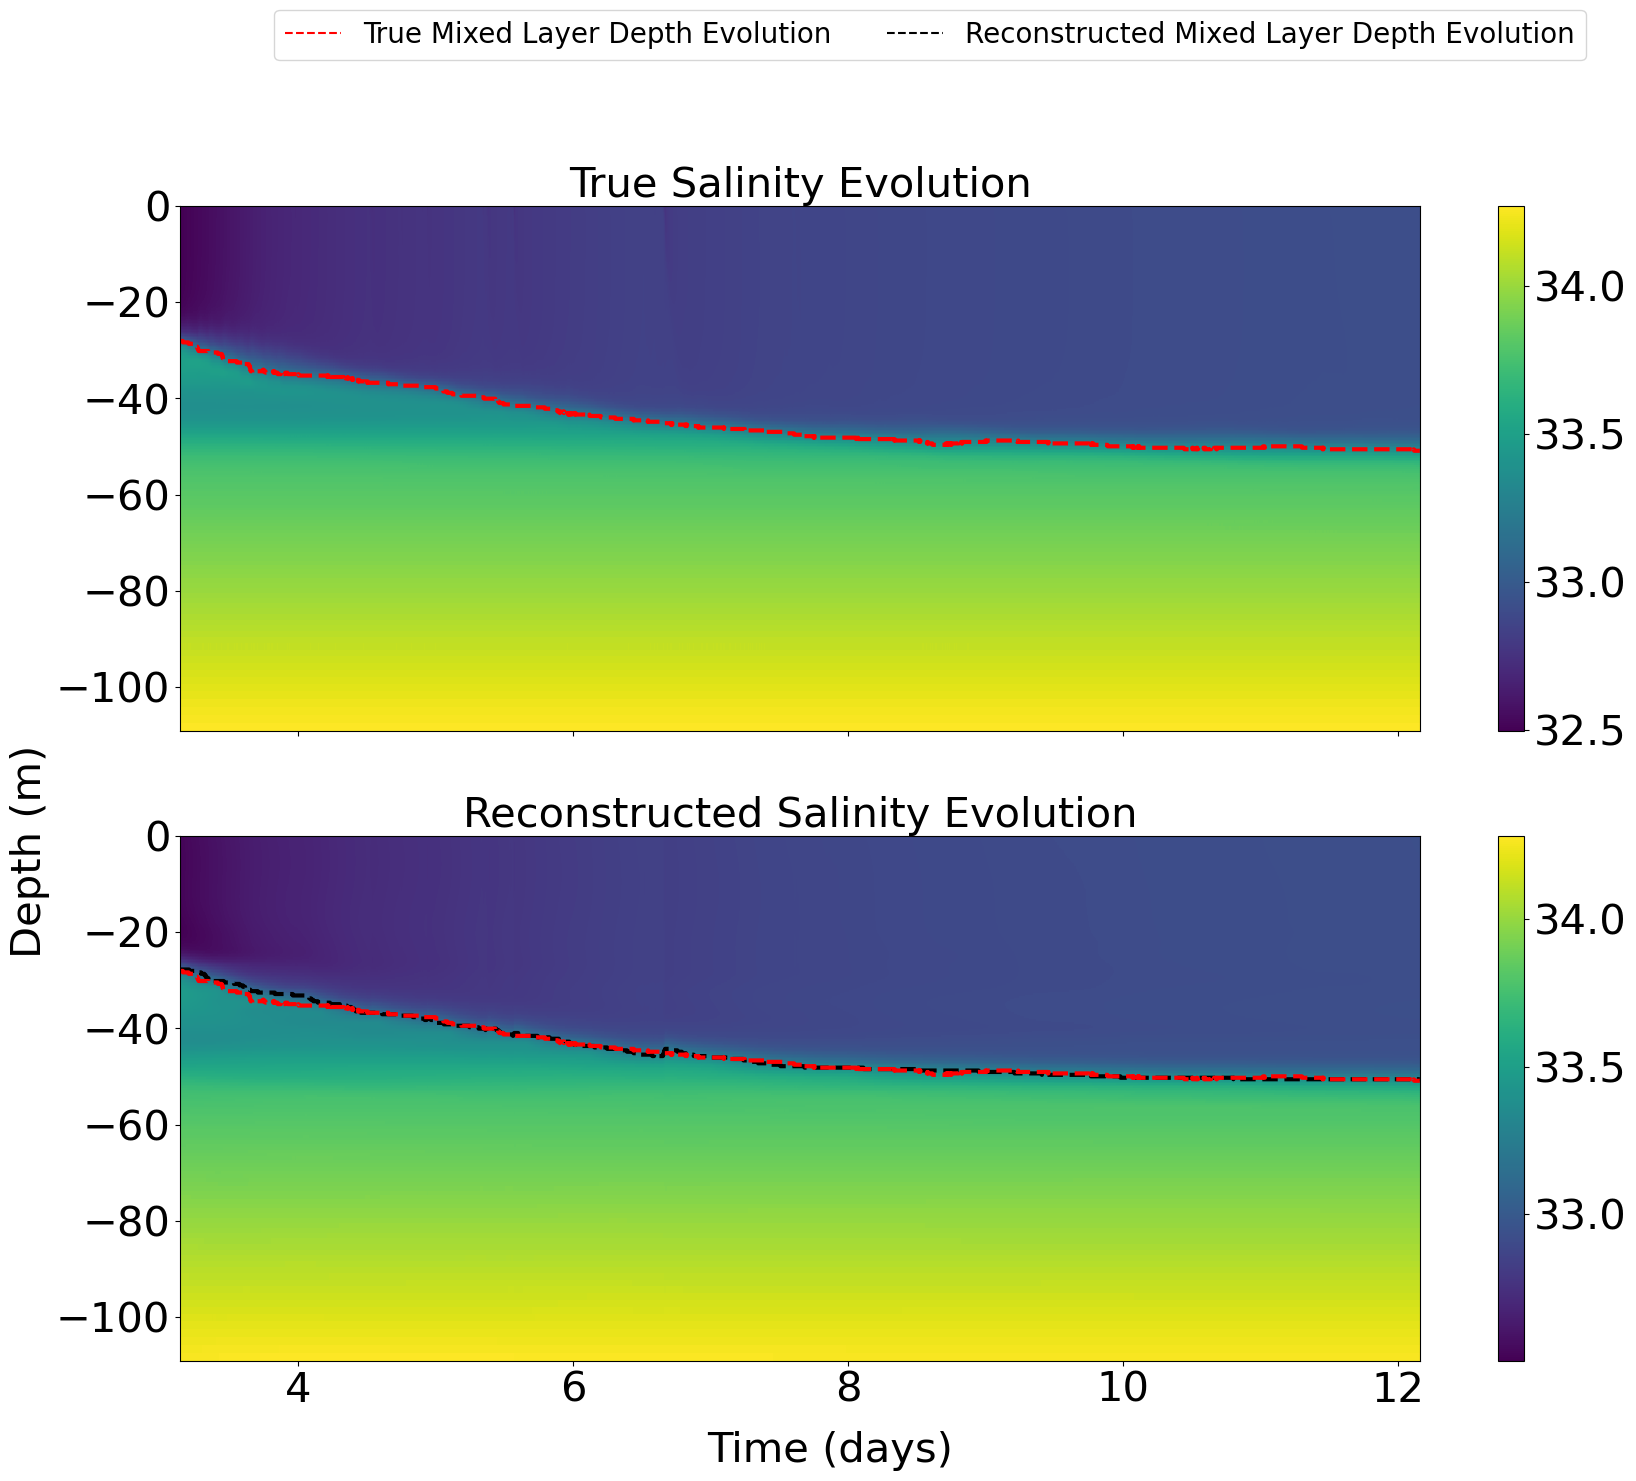

In [ ]:
#pcolor plots
t=np.linspace(1500,3500,2000,endpoint=False)
[xx, tt] = np.meshgrid(ZZ[:,1:].flatten(), hours[1500:endtime]/24)
label_font = {'family': 'serif', 'weight': 'bold', 'size': 18}
fig,ax=plt.subplots(2,1,figsize=(20,15),sharex=True)


a=ax[1].pcolormesh(tt,xx,In.inv_transform(x_rec1[time_step:,:,:].cpu().detach().numpy())[:,1:,0],label='predicted')
b=ax[0].pcolormesh(tt,xx,In.inv_transform(Testx_tr1[time_step:,:,:])[:,1:,0],label='actual')
ax[1].set_title('Reconstructed Salinity Evolution',fontsize=30)
ax[0].set_title('True Salinity Evolution',fontsize=30)
cbar1=fig.colorbar(b,ax=ax[0])
cbar2=fig.colorbar(a,ax=ax[1])

cbar1.ax.tick_params(axis='both', labelsize=30)
cbar2.ax.tick_params(axis='both', labelsize=30)


ax[0].plot(hours[1500:endtime] / 24, coordinatemaxTr[time_step:].flatten(), '--', color='red', linewidth=3.0)

ax[1].plot(hours[1500:endtime] / 24, coordinatemaxpred1[time_step:].flatten(), '--', color='black', linewidth=3.0)
ax[1].plot(hours[1500:endtime] / 24, coordinatemaxTr[time_step:].flatten(), '--', color='red', linewidth=3.0)


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', lw=1.5, linestyle='--', label='True Mixed Layer Depth Evolution'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='--', label='Reconstructed Mixed Layer Depth Evolution')
]
fig.legend(handles=legend_elements, loc='upper center', fontsize=20, bbox_to_anchor=(0.5, 1.02), ncol=3)



ax[0].tick_params(axis='both', labelsize=30)
ax[1].tick_params(axis='both', labelsize=30)

fig.text(0.45, 0.05, 'Time (days)', ha='center', va='center',font={'size': 30})
fig.text(0.05, 0.45, 'Depth (m)', ha='center', va='center', rotation='vertical',font={'size': 30})


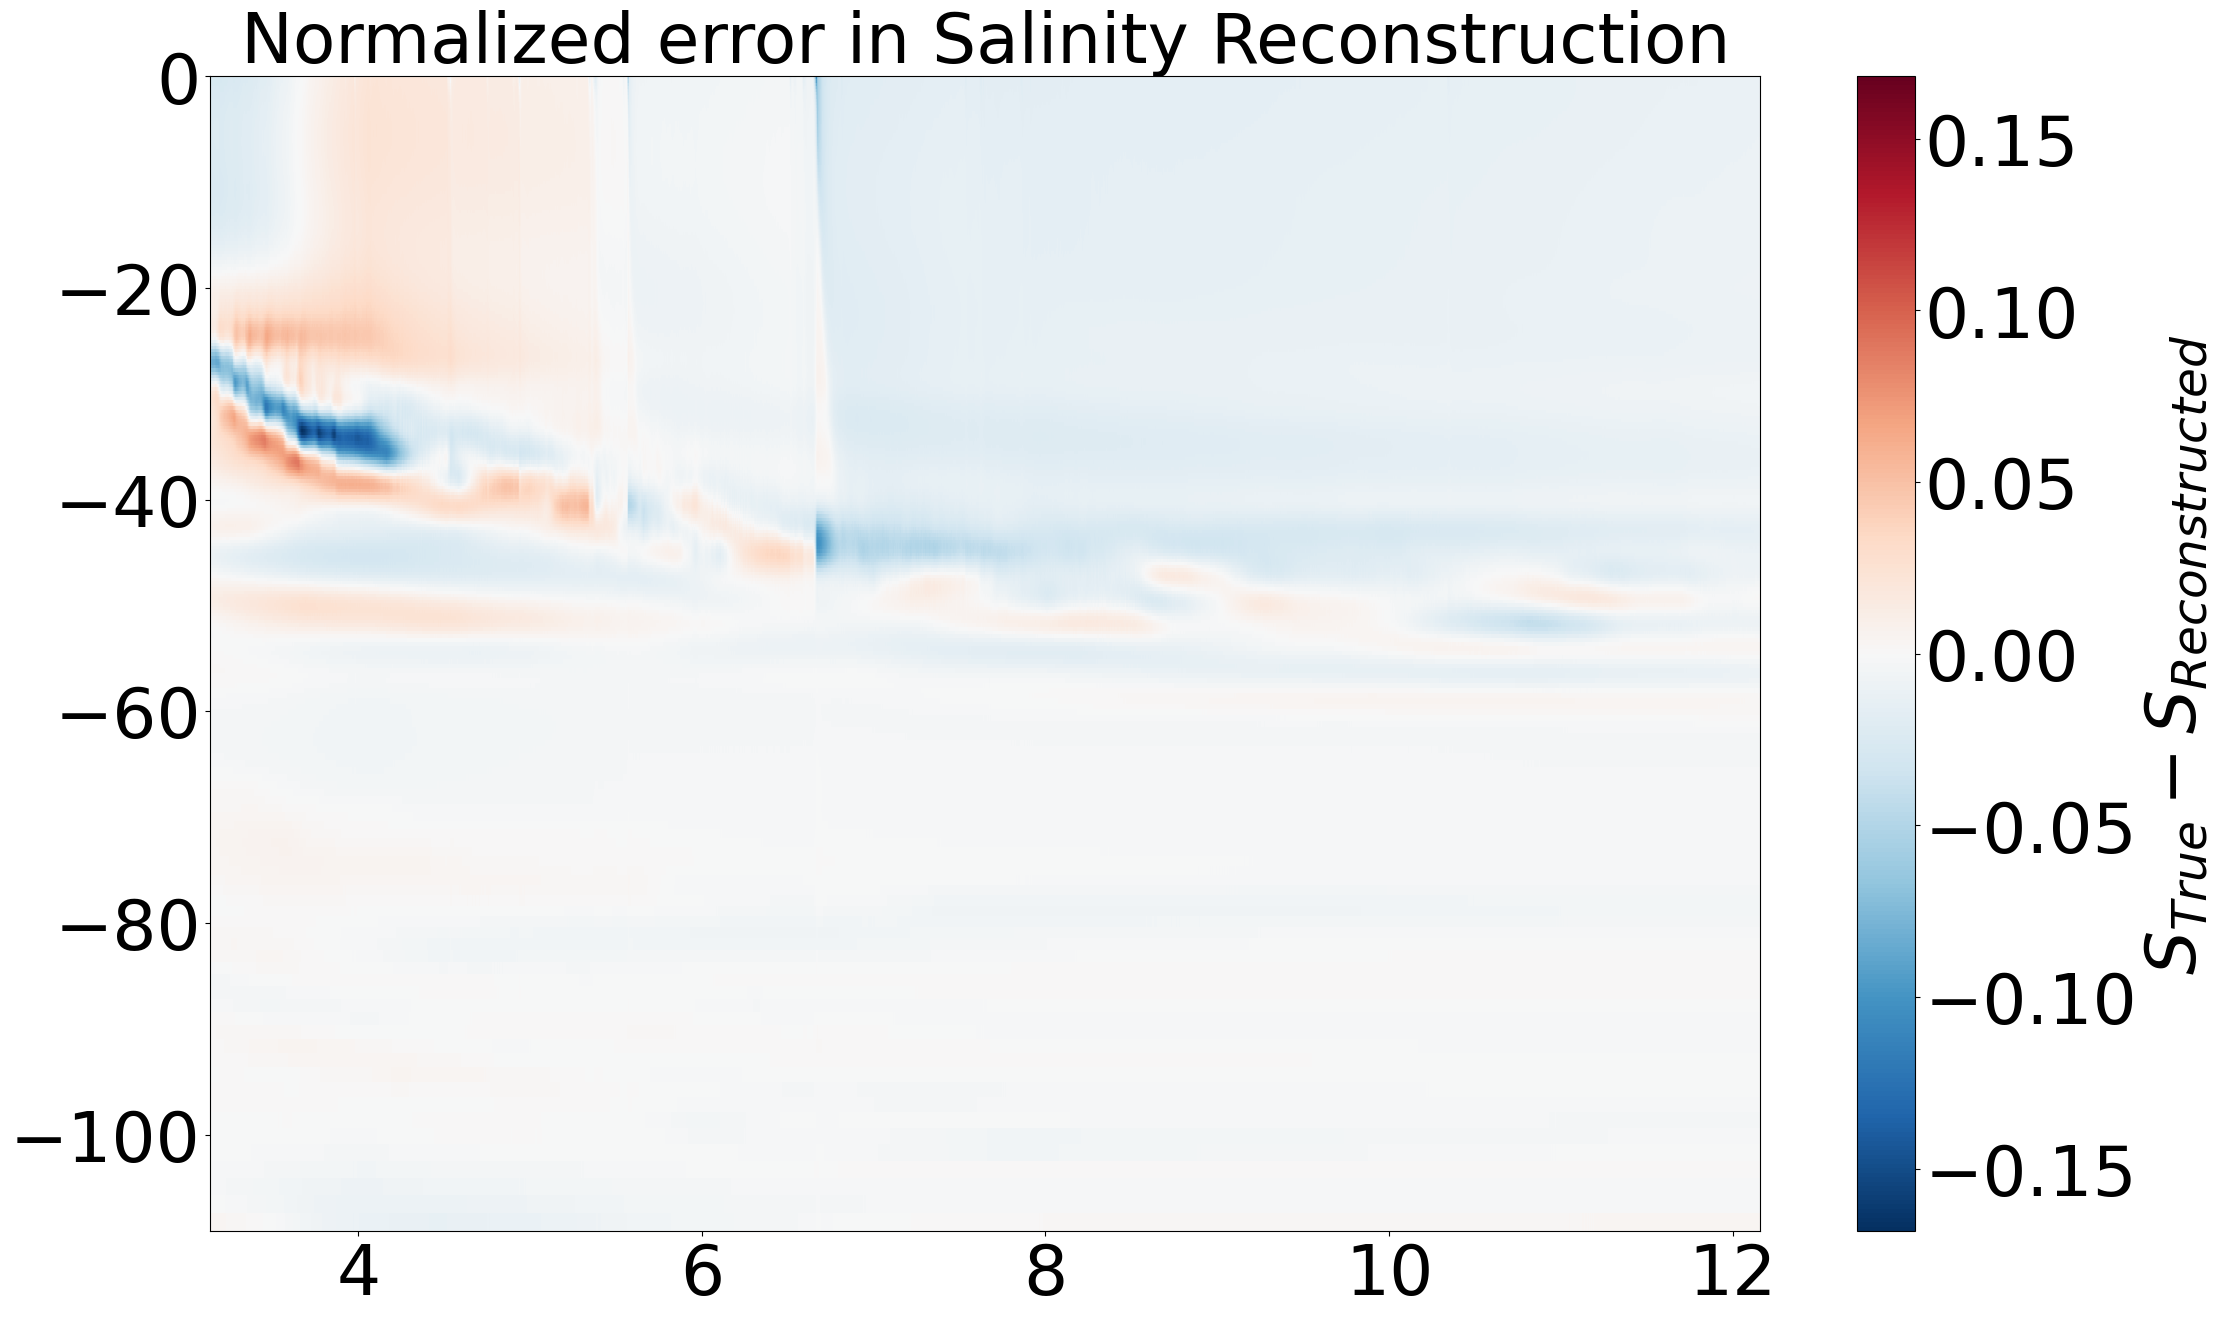

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(25, 15))
from matplotlib.colors import Normalize


data = In.inv_transform(Testx_tr1[time_step:,:,:])[:,1:,0] - In.inv_transform(x_rec1[time_step:,:,:].cpu().detach().numpy())[:,1:,0]
max_val = np.max(np.abs(data))


norm = Normalize(vmin=-max_val, vmax=max_val)


im = ax.pcolormesh(
    tt, xx, data, 
    label='predicted', norm=norm, cmap="RdBu_r"
)

# Set title and configure colorbar
ax.set_title('Normalized error in Salinity Reconstruction', fontsize=50)
ax.tick_params(axis='both', labelsize=50)

# Configure colorbar with LaTeX label formatting
colo = plt.colorbar(im, ax=ax)
colo.set_label(r'$S_{True} - S_{Reconstructed}$', fontsize=50)
colo.ax.tick_params(axis='both', labelsize=50)

plt.show()


## Prepare the data for Temporal evolution

In [ ]:
# Data for training LSTM and DNN

out,reduced_Train= model((torch.tensor(x_tr[:,:,:]).to(device)))

outv,reduced_val=model(torch.tensor(Valx_tr[:,:,:]).to(device))

outT,reduced_test=model(torch.tensor(Testx_tr[:,:,:]).to(device))

print(reduced_Train.shape)
print(reduced_val.shape)
print(reduced_test.shape)

torch.Size([3700, 3])
torch.Size([300, 3])
torch.Size([6010, 3])


In [ ]:
# 1500-7500
reduced_all=torch.cat([reduced_Train[0:1500],reduced_test[time_step:time_step+1500],reduced_val,reduced_Train[1500:2700],reduced_test[time_step+3000:],reduced_Train[2700:]])

Text(0.5, 0.98, 'Evolution of three Latent space variables ')

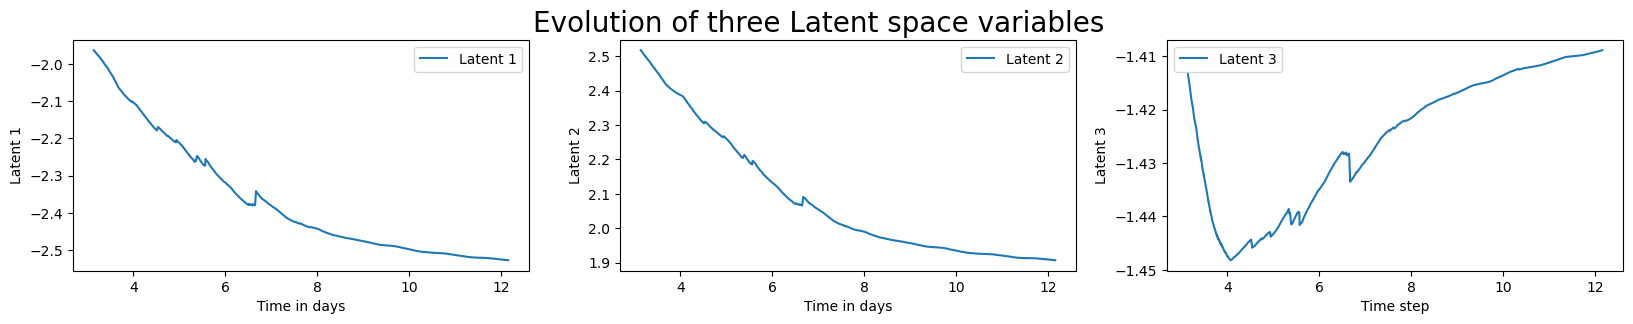

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,3))
Start=1500
End=7500
stride=1
days=hours/24
#ax[0].plot(Test_encodings_actual[Start:End:stride, 0],label='Actual')
ax[0].plot(days[Start:End],reduced_all.cpu().detach().numpy()[Start:End:stride, 0],label='Latent 1')
#ax[0].scatter(days[Start:End],reduced_all.cpu().detach().numpy()[Start:End:stride, 0],label='Latent 1')
ax[0].set_xlabel('Time in days')
ax[0].set_ylabel('Latent 1')

#ax[1].plot(Test_encodings_actual[Start:End:stride, 1],label='Actual')
ax[1].plot(days[Start:End],reduced_all.cpu().detach().numpy()[Start:End:stride, 1],label='Latent 2')
ax[1].set_xlabel('Time in days')
ax[1].set_ylabel('Latent 2')

#ax[2].plot(Test_encodings_actual[Start:End:stride, 2],label='Actual')
ax[2].plot(days[Start:End],reduced_all.cpu().detach().numpy()[Start:End:stride, 2],label='Latent 3')
ax[2].set_xlabel('Time step')
ax[2].set_ylabel('Latent 3')

'''ax[3].plot(days[Start:End],reduced_all.cpu().detach().numpy()[Start:End:stride, 3],label='Latent 4')
ax[3].set_xlabel('Time step')
ax[3].set_ylabel('Latent 4')

ax[4].plot(days[Start:End],reduced_all.cpu().detach().numpy()[Start:End:stride, 4],label='Latent 5')
ax[4].set_xlabel('Time step')
ax[4].set_ylabel('Latent 5')
'''
ax[0].legend()
ax[1].legend()
ax[2].legend()
'''ax[3].legend()
ax[4].legend()'''

plt.suptitle('Evolution of three Latent space variables ',fontsize=20)

In [ ]:
filename1='reduced_all.mat'

reduced_al={'red_all':reduced_all.cpu().detach().numpy()}

scipy.io.savemat(filename1,reduced_al)


## Load Boundary conditions for Temporal Evolution

In [ ]:
#Interpolated plus 1500-2500 with validation between 2500-2800 
Input_BC=loadmat("Input_BC")
B_C=Input_BC['BC'].astype(np.float32)

BC1=B_C[0:1500,[1,2,5]]
BC2=B_C[3300:4500,[1,2,5]]

# Adding final break phase data

BC3=B_C[7500:8500,[1,2,5]]

BC_train=np.concatenate([BC1,BC2,BC3],axis=0)

bc=MinMaxScaler()
BC_train=bc.fit_transform(BC_train)
BC_val=B_C[3000:3300,[1,2,5]]

BC_val=bc.transform(BC_val)


BC_test=B_C[1500-time_step_test:endtime,[1,2,5]]
BC_test=bc.transform(BC_test)
print(BC_train.shape)
print(B_C.shape)

(3700, 3)
(8501, 6)


In [ ]:
BC_cond=3

## Forming Input/Output pairs for training Temporal Evolution

In [ ]:
#  1500-3000(also 8000-8500 for predicting future); validattion 3000-3300; Test(1500-8500)
Train_In=np.zeros((reduced_Train.shape[0]-time_step*6,time_step,encoded_size+BC_cond))
Train_Out=np.zeros((reduced_Train.shape[0]-time_step*6,encoded_size*time_step))

print(reduced_Train.shape)

j=0
for i in range(0,1500-2*time_step):
    Train_In[j,:,0:encoded_size]=reduced_Train[i:i+time_step,:].cpu().detach().numpy()
    Train_In[j,:,encoded_size:]=BC_train[i:i+time_step,:]
    Train_Out[j,:]=(reduced_Train[i+time_step:i+2*time_step,:].cpu().detach().numpy()).reshape(1,encoded_size*time_step)
    j=j+1
    
for i in range(1500,2700-2*time_step):
    Train_In[j,:,0:encoded_size]=reduced_Train[i:i+time_step,:].cpu().detach().numpy()
    Train_In[j,:,encoded_size:]=BC_train[i:i+time_step,:]
    Train_Out[j,:]=(reduced_Train[i+time_step:i+2*time_step,:].cpu().detach().numpy()).reshape(1,encoded_size*time_step)
    j=j+1
    
# Adding Final break phase data(8000-8500)

for i in range(2700,3700-2*time_step):
    Train_In[j,:,0:encoded_size]=reduced_Train[i:i+time_step,:].cpu().detach().numpy()
    Train_In[j,:,encoded_size:]=BC_train[i:i+time_step,:]
    Train_Out[j,:]=(reduced_Train[i+time_step:i+2*time_step,:].cpu().detach().numpy()).reshape(1,encoded_size*time_step)
    j=j+1

Val_In=np.zeros((reduced_val.shape[0]-2*time_step,time_step,encoded_size+BC_cond))
Val_Out=np.zeros((reduced_val.shape[0]-2*time_step,encoded_size*time_step))


for i in range(300-2*time_step):
    Val_In[i,:,0:encoded_size]=reduced_val[i:i+time_step,:].cpu().detach().numpy()
    Val_In[i,:,encoded_size:]=BC_val[i:i+time_step,:]
    Val_Out[i,:]=reduced_val[i+time_step:i+2*time_step,:].cpu().detach().numpy().reshape(1,encoded_size*time_step)
    

print(Val_In.shape)

Test_In=np.zeros((reduced_test.shape[0]-2*time_step,time_step,encoded_size+BC_cond))
Test_Out=np.zeros((reduced_test.shape[0]-2*time_step,encoded_size*time_step))


jj=0
for i in range(0,6000-time_step):
    Test_In[jj,:,0:encoded_size]=reduced_test[i:i+time_step,:].cpu().detach().numpy()
    Test_In[jj,:,encoded_size:]=BC_test[i:i+time_step,:]
    Test_Out[jj,:]=reduced_test[i+time_step:i+2*time_step,:].cpu().detach().numpy().reshape(1,encoded_size*time_step)
    jj=jj+1

print(Test_In.shape)

torch.Size([3700, 3])
(280, 10, 6)
(5990, 10, 6)


In [ ]:

print(Train_In.shape)
print(Train_Out.shape)

print(Val_In.shape)
print(Val_Out.shape)

print(Test_In.shape)
print(Test_Out.shape)

(3660, 10, 6)
(3660, 30)
(280, 10, 6)
(280, 30)
(5990, 10, 6)
(5990, 30)


## Saving the array to be later used for training temporal Evolution

In [ ]:

filename1='TrainingIn.mat'

reduced_train_In={'red_train':Train_In}
filename2='TrainingOut.mat'
reduced_train_Out={'red_train':Train_Out}

scipy.io.savemat(filename1,reduced_train_In)
scipy.io.savemat(filename2,reduced_train_Out)

filename3='Validation_In.mat'
filename4='Validation_Out.mat'

reduced_val_In={'val_train':Val_In}
reduced_val_Out={'val_train':Val_Out}

scipy.io.savemat(filename3,reduced_val_In)
scipy.io.savemat(filename4,reduced_val_Out)


filename3='Test_In.mat'
filename4='Test_Out.mat'

reduced_test_In={'red_test':Test_In}
reduced_test_Out={'red_test':Test_Out}

scipy.io.savemat(filename3,reduced_test_In)
scipy.io.savemat(filename4,reduced_test_Out)

In [ ]:
# Test initial condition
Test_In=np.zeros((1,time_step_test,encoded_size+BC_cond))
Test_In[0,:,0:encoded_size]=reduced_test[0:time_step_test,:].cpu().detach().numpy()
Test_In[0,:,encoded_size:]=BC_test[0:time_step_test,0:]


filename5='Test_Inital.mat'
Test_init={'Test':Test_In}


scipy.io.savemat(filename5,Test_init)
#scipy.io.savemat(filename8,Time_init)

filename6='BC_test.mat'
BC_tests={'BC_test':BC_test[:,0:]}
scipy.io.savemat(filename6,BC_tests)




Test_In_all=np.zeros((29,time_step_test,encoded_size))
print(reduced_test[time_step:,:].shape)

Test_In_all=reduced_test[time_step:,:].cpu().detach().numpy()

print(Test_In_all.shape)

filename7='Test_Set.mat'
Test_In_set={'Test_Set':Test_In_all}

scipy.io.savemat(filename7,Test_In_set)


torch.Size([6000, 3])
(6000, 3)


In [ ]:
Val_In=np.zeros((1,time_step_test,encoded_size+BC_cond))

Val_In[0,:,0:encoded_size]=reduced_val[0:time_step_test,:].cpu().detach().numpy()
Val_In[0,:,encoded_size:]=BC_val[0:time_step_test,:]

filename5='Val_Inital.mat'
Val_init={'Val':Val_In}

scipy.io.savemat(filename5,Val_init)

filename6='BC_val.mat'
BC_val={'BC_val':BC_val}

scipy.io.savemat(filename6,BC_val)

Val_In_all=np.zeros((29,time_step_test,encoded_size))
print(reduced_val[:,:].shape)

Val_In_all=reduced_val[:,:].cpu().detach().numpy()

print(Val_In_all.shape)

filename7='Val_Set.mat'
Val_In_set={'Val_Set':Val_In_all}

scipy.io.savemat(filename7,Val_In_set)

torch.Size([300, 3])
(300, 3)


### Next Go to the Python Notebook named ILSTM_Tempo_DNN-Salinity.ipynb to train the GRU for temporal Evolution and then come back to this notebook once finished for decoding the profiles

## Decoding from predictions 

In [ ]:
pred=loadmat('predictions_encodings.mat')
predictions_enc=pred['pred']
print(predictions_enc.shape)
predictions_enc=torch.from_numpy(predictions_enc).float().to(device)

(6000, 3)


In [ ]:
x=torch.zeros(3000, 240, 5).to(device)
decoded_predictions=model.decoder(predictions_enc,x)

In [ ]:
Truex=Input[1500:endtime,:,:]
True_tr=In.transform(Truex)


In [ ]:
decoded_predictions1=np.zeros((decoded_predictions.shape[0],240,1))
True_tr1=np.zeros((True_tr.shape[0],240,1))

for i in range(decoded_predictions.shape[0]): 
    decoded_predictions1[i,:,:]=griddata(xi,decoded_predictions[i,:,0:1].cpu().detach().numpy(),points,method='cubic')
    True_tr1[i,:,:]=griddata(xi,True_tr[i,:,0:1],points,method='cubic')
    
print(decoded_predictions1.shape)
#print(True_tr1.shape)

decoded_predictions=torch.from_numpy(decoded_predictions1)
True_tr=torch.from_numpy(True_tr1)

In [ ]:
print(decoded_predictions.shape)
print(True_tr.shape)

torch.Size([6000, 240, 1])
torch.Size([6000, 240, 1])


## Final Results of the RNN-ROM to predict the Salinity profiles

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(20,30),sharey=True,squeeze=True)
days=hours/24
p = 0
timeSteps=p+1500
for i in range(3):
    for j in range(2):
        ax[i, j].plot(In.inv_transform(True_tr[p,:,:])[:,:,0].T,ZZ.T,label='True')
        ax[i, j].plot(In.inv_transform(decoded_predictions[p,:,:].detach().numpy())[:,:,0].T,ZZ.T,label='Predicted')
        if j==0:
            ax[i, j].set_ylabel('Depth (m)',fontsize=40)
        ax[i, j].legend(['True','Predicted'], fontsize=30)
        ax[i, j].set_title(f'Salinity profile at day=%1.3f' % days[timeSteps], fontsize=40)
        ax[i,j].tick_params(axis='both', labelsize=40)
        ax[i, j].set_xlabel('Salinity (psu)',fontsize=40)

        p += 1166 ## 1166 for 1500-8500
        timeSteps += 1166  ## 1166 gfor 1500-8500

plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()

"ax[0].plot(In.inv_transform(decoded_predictions[:,:,:].cpu().detach().numpy())[:,-1,1], label='Predicted')\nax[0].plot(In.inv_transform(True_tr)[:,-1,1], label='True')\nax[0].set_title(f'Comparison between LES and LSTM-ROM SSS for k={time_step}')\nax[0].legend()"

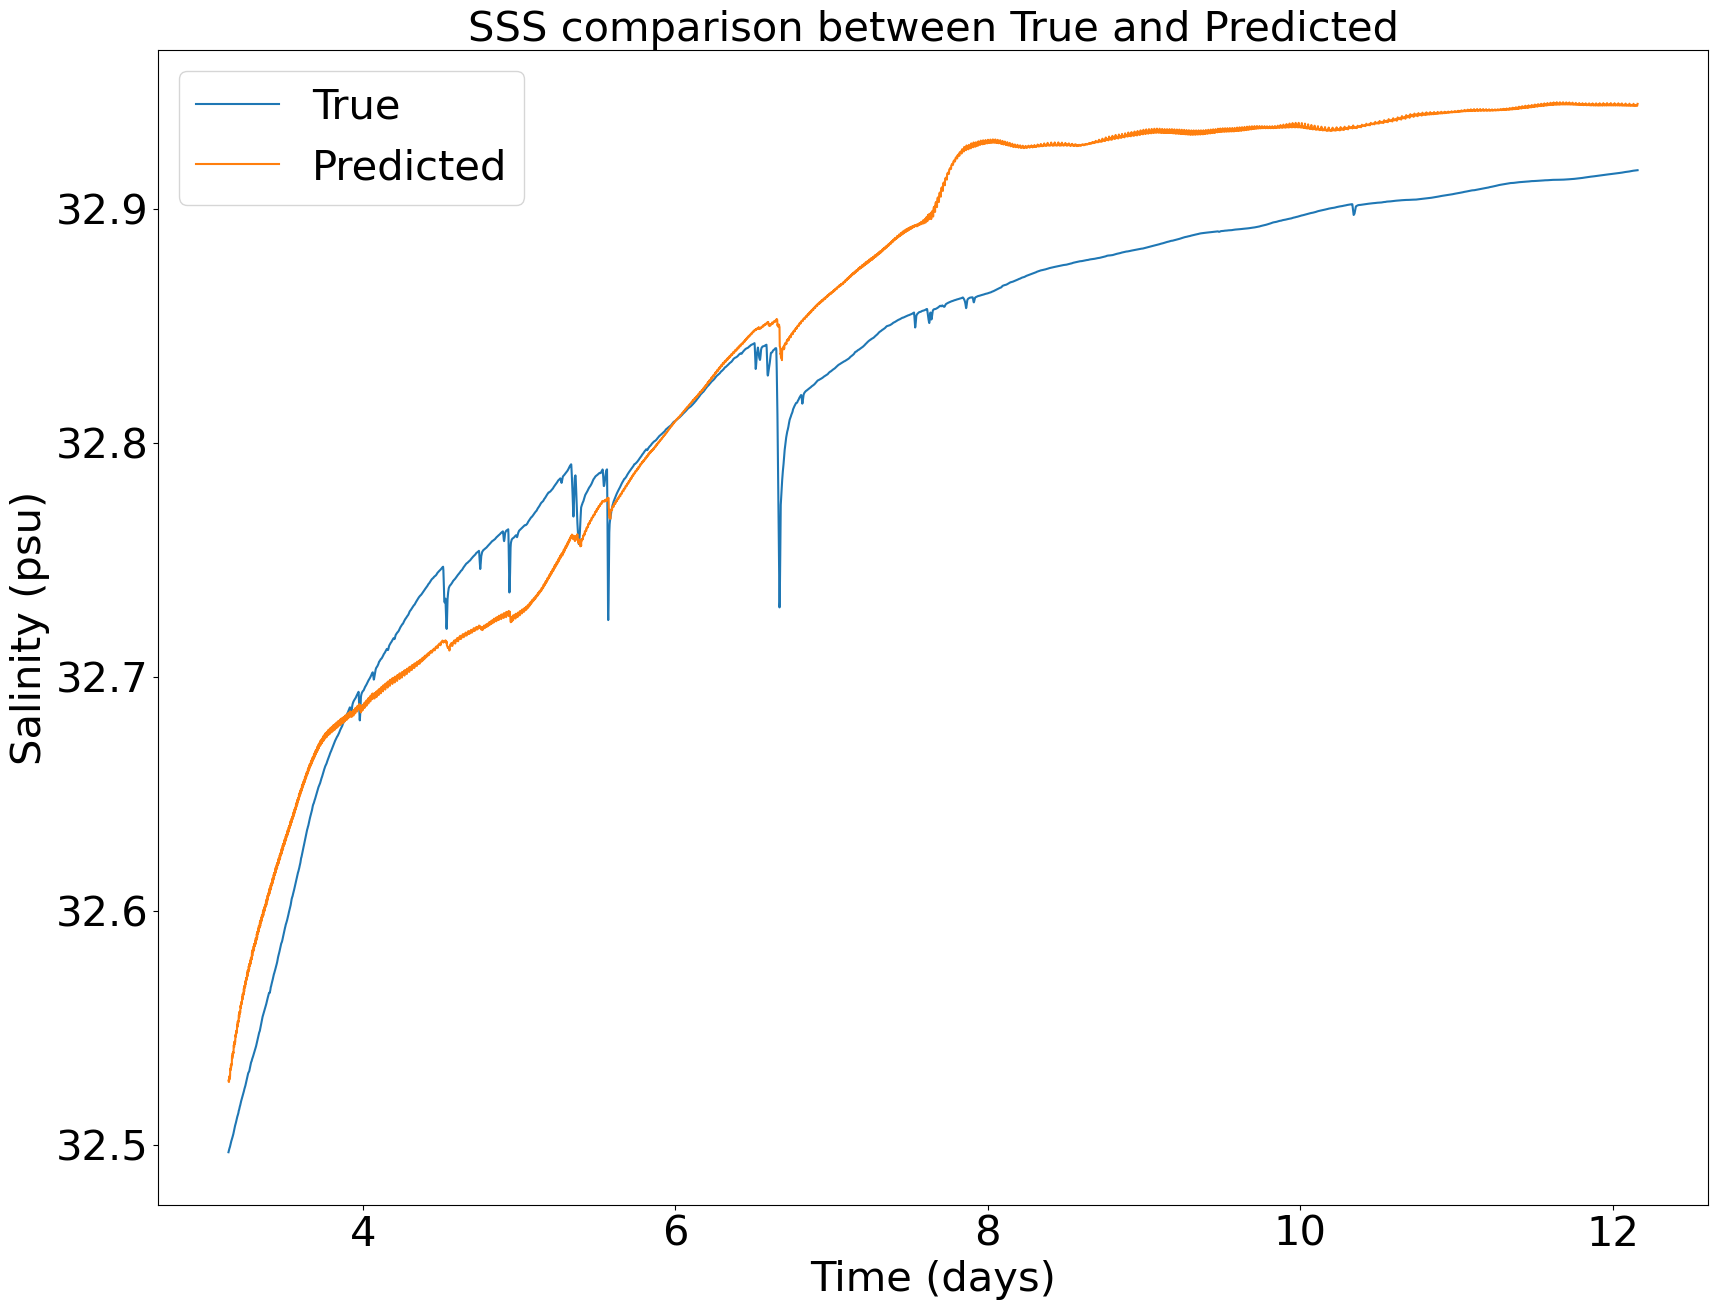

In [ ]:
fig,ax= plt.subplots(1,1,figsize=(20,15))
t=np.linspace(7000,8501,1501,endpoint=False)
ax.plot(hours[1500:endtime]/24,In.inv_transform(True_tr)[:,-1,0],label='True')
ax.plot(hours[1500:endtime]/24,In.inv_transform(decoded_predictions.detach().numpy())[:,-1,0],label='Predicted')

ax.set_xlabel('Time (days)',fontsize=30)
ax.set_ylabel('Salinity (psu)',fontsize=30)
ax.set_title('SSS comparison between True and Predicted',fontsize=30)
ax.legend(fontsize=30)
ax.tick_params(axis='both', labelsize=30)

In [ ]:
print(True_tr.shape)

torch.Size([6000, 240, 1])


In [ ]:

# Finding the coordinate of maximum temperature.
Testxx=np.copy(True_tr)
for i in range(True_tr.shape[0]):
    Testxx[i,0,0]=True_tr[i,1,0]

coordinatemaxTr=np.zeros((True_tr.shape[0],1))
dTestxx=np.zeros((Testxx.shape[0],Testxx.shape[1]-1,1))
for i in range(Testxx.shape[0]):
    dTestxx[i,:,:]=np.abs((Testxx[i,1:,0:1]-Testxx[i,:-1,0:1])/(ZZ[0:1,1:].T-ZZ[0:1,:-1].T))
    maxarg =np.argmax(dTestxx[i,:,:])
    coordinatemaxTr[i,0]=ZZ[0,maxarg]                   
                        

Testxx=np.copy(decoded_predictions)
for i in range(decoded_predictions.shape[0]):
    Testxx[i,0,0]=decoded_predictions[i,1,0:1]

coordinatemaxpred1=np.zeros((decoded_predictions.shape[0],1))
dTestxx=np.zeros((Testxx.shape[0],Testxx.shape[1]-1,1))
for i in range(Testxx.shape[0]):
    dTestxx[i,:,:]=np.abs((Testxx[i,1:,0:1]-Testxx[i,:-1,0:1])/(ZZ[0:1,1:].T-ZZ[0:1,:-1].T))
    maxarg =np.argmax(dTestxx[i,:,:])
    coordinatemaxpred1[i,0]=ZZ[0,maxarg]       



In [ ]:
print(np.max(np.abs(coordinatemaxTr-coordinatemaxpred1)))

2.4173019999999994


Text(0.05, 0.45, 'Depth (meters)')

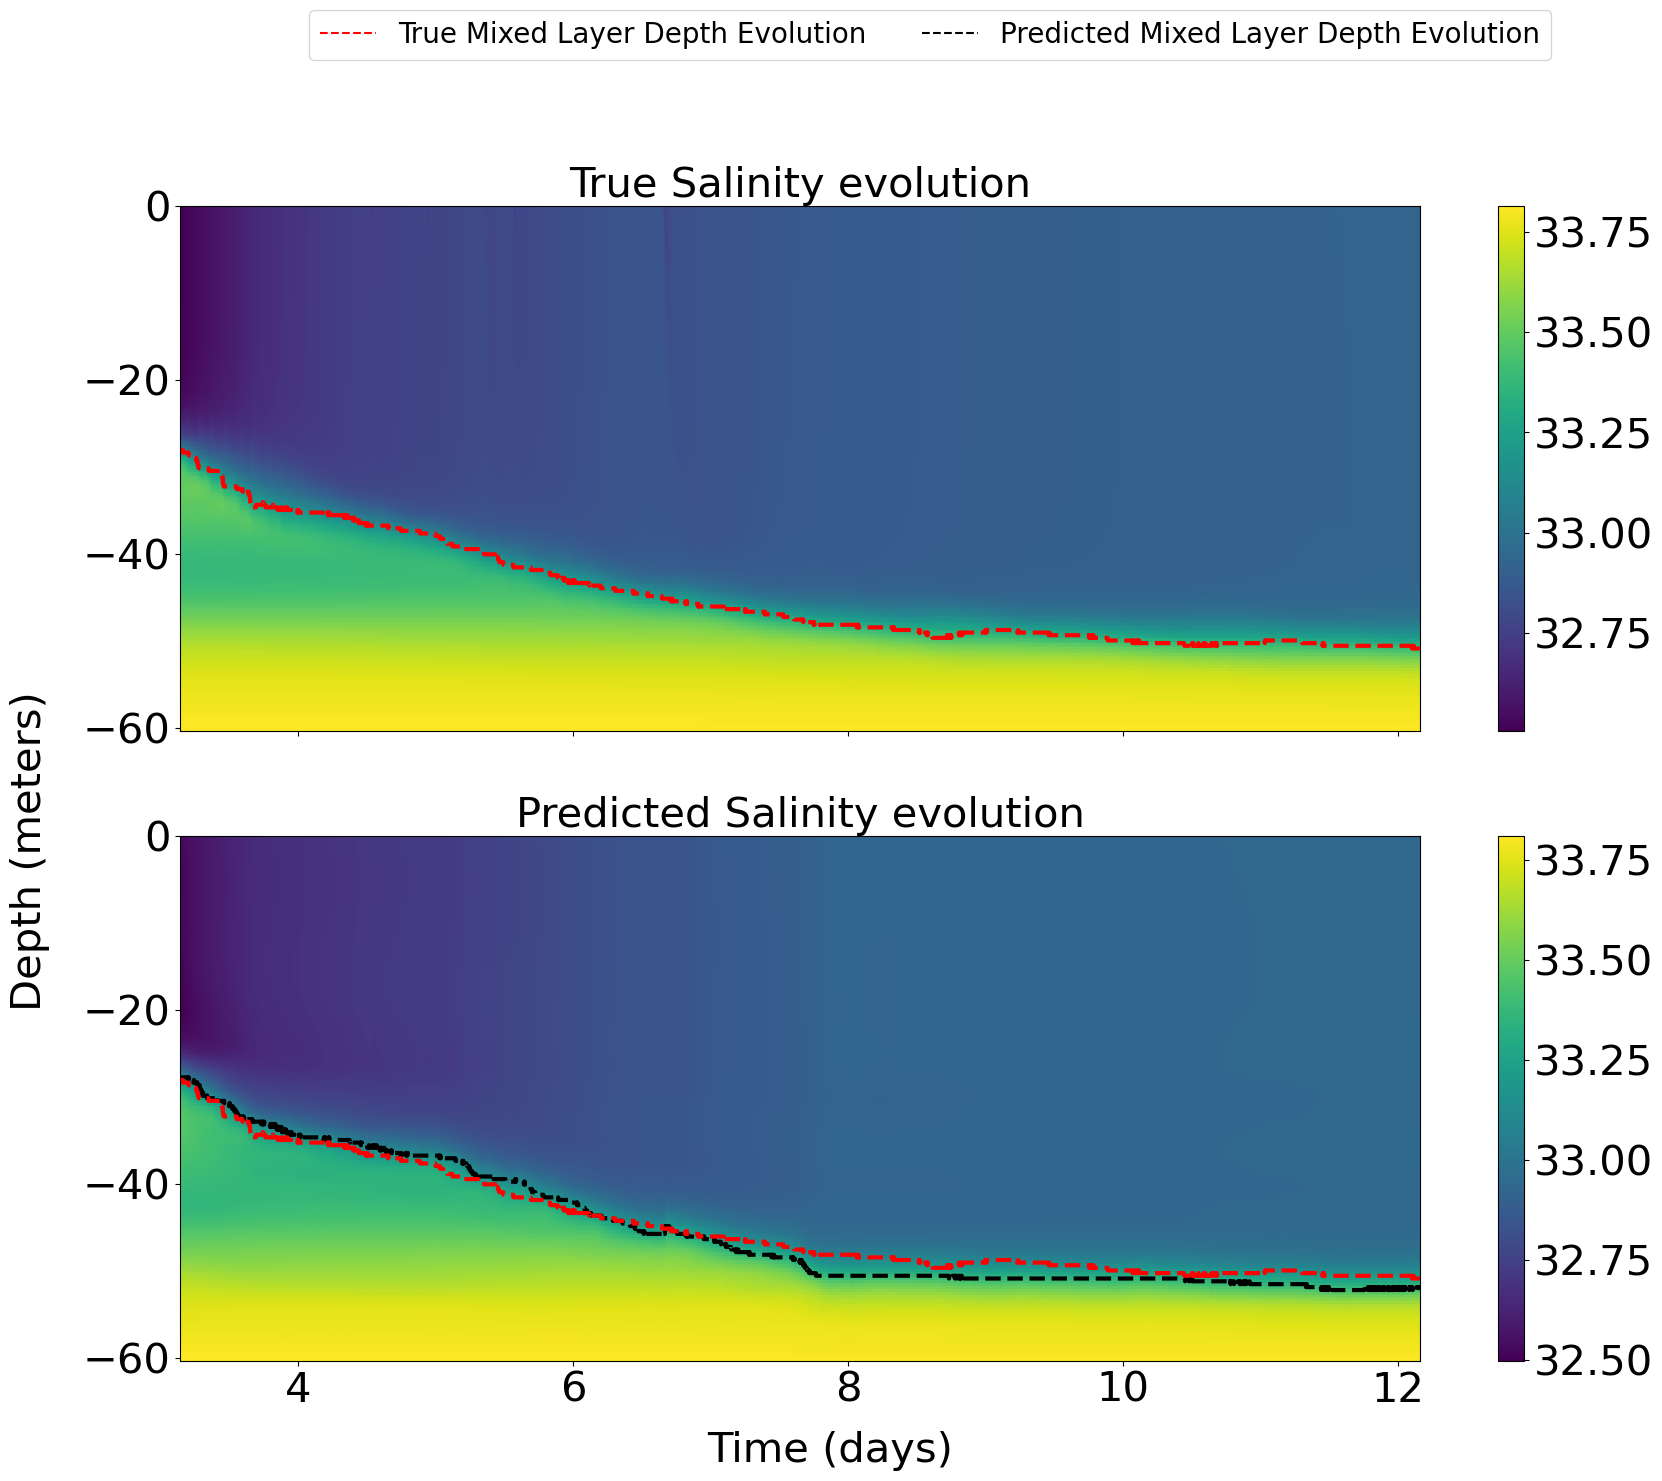

In [ ]:
#pcolor plots
t=np.linspace(1000,4999,3999,endpoint=False)
[xx, tt] = np.meshgrid(ZZ[:,1:].flatten(), days[1500:endtime])
label_font = {'family': 'serif', 'weight': 'bold', 'size': 18}
fig,ax=plt.subplots(2,1,figsize=(20,15),sharex=True)

endgrid=48
a=ax[0].pcolormesh(tt[:,endgrid-1:],xx[:,endgrid-1:],In.inv_transform(True_tr[:,endgrid:,:])[:,:,0],label='actual')
b=ax[1].pcolormesh(tt[:,endgrid-1:],xx[:,endgrid-1:],In.inv_transform(decoded_predictions[:,endgrid:,:].cpu().detach().numpy())[:,:,0],label='predicted')

ax[0].set_title('True Salinity evolution',fontsize=30)
ax[1].set_title('Predicted Salinity evolution',fontsize=30)
cbar1=fig.colorbar(b,ax=ax[0])
cbar2=fig.colorbar(a,ax=ax[1])

cbar1.ax.tick_params(axis='both', labelsize=30)
cbar2.ax.tick_params(axis='both', labelsize=30)

ax[0].plot(hours[1500:endtime] / 24, coordinatemaxTr[:].flatten(), '--', color='red', linewidth=3.0)

ax[1].plot(hours[1500:endtime] / 24, coordinatemaxpred1[:].flatten(), '--', color='black', linewidth=3.0)
ax[1].plot(hours[1500:endtime] / 24, coordinatemaxTr[:].flatten(), '--', color='red', linewidth=3.0)


from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', lw=1.5, linestyle='--', label='True Mixed Layer Depth Evolution'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='--', label='Predicted Mixed Layer Depth Evolution')
]
fig.legend(handles=legend_elements, loc='upper center', fontsize=20, bbox_to_anchor=(0.5, 1.02), ncol=3)
           


ax[0].tick_params(axis='both', labelsize=30)
ax[1].tick_params(axis='both', labelsize=30)

fig.text(0.45, 0.05, 'Time (days)', ha='center', va='center',font={'size': 30})
fig.text(0.05, 0.45, 'Depth (meters)', ha='center', va='center', rotation='vertical',font={'size': 30})


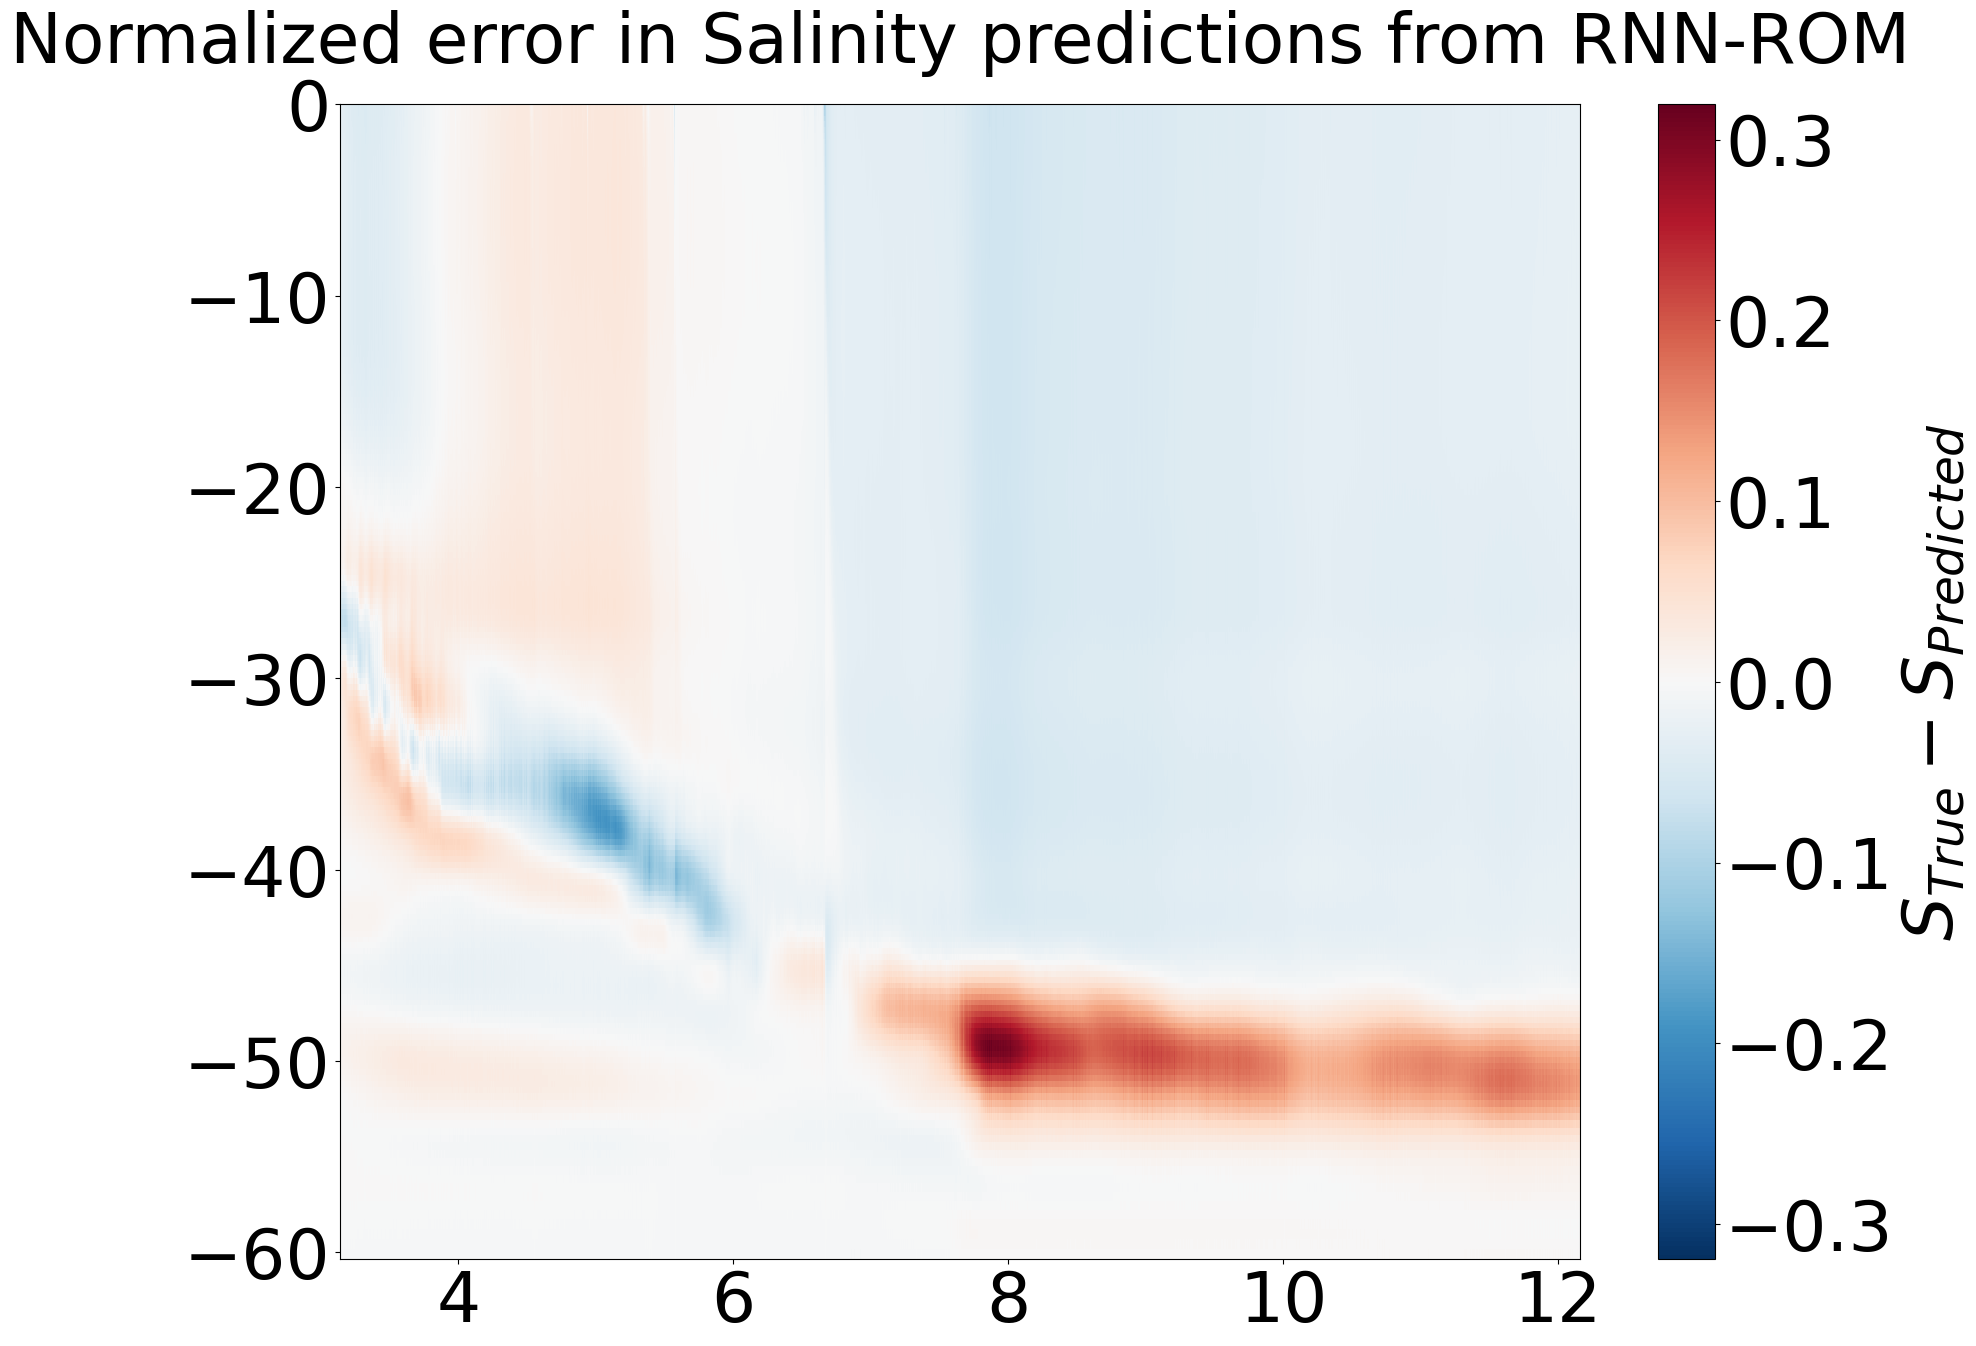

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
from matplotlib.colors import Normalize

# Calculate the normalized error 
data = In.inv_transform(True_tr[:,:,:].cpu().detach().numpy())[:,1:,0] - In.inv_transform(decoded_predictions[:,:,:].cpu().detach().numpy())[:,1:,0]
max_val = np.max(np.abs(data))


norm = Normalize(vmin=-max_val, vmax=max_val)

data = In.inv_transform(True_tr[:,endgrid:,:].cpu().detach().numpy())[:,:,0] - In.inv_transform(decoded_predictions[:,endgrid:,:].cpu().detach().numpy())[:,:,0]


im = ax.pcolormesh(
    tt[:,endgrid-1:], xx[:,endgrid-1:], data,
    label='predicted', norm=norm, cmap="RdBu_r"
)


ax.set_title('Normalized error in Salinity predictions from RNN-ROM', fontsize=50, pad=30)
ax.tick_params(axis='both', labelsize=50)


colo = plt.colorbar(im, ax=ax)
colo.set_label(r'$S_{True} - S_{Predicted}$', fontsize=50)
colo.ax.tick_params(axis='both', labelsize=50)

plt.show()


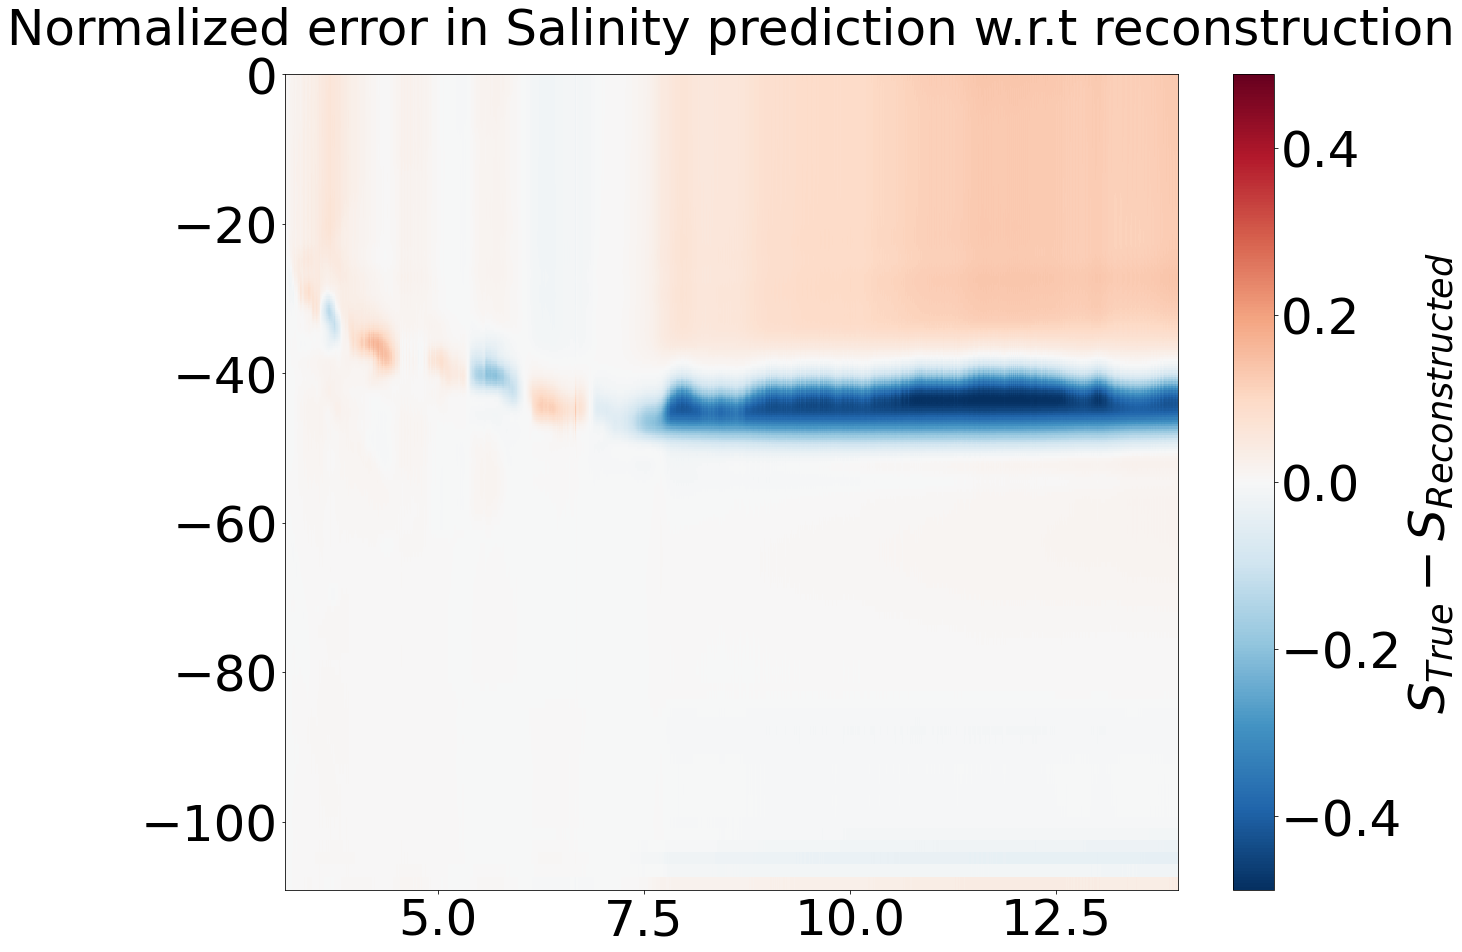

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
from matplotlib.colors import Normalize

# Calculate the error with respect to the reconstruction
data = In.inv_transform(x_rec1[time_step:,:,:].cpu().detach().numpy())[:,1:,0] - In.inv_transform(decoded_predictions[:,:,:].cpu().detach().numpy())[:,1:,0]

max_val = np.max(np.abs(data))
norm = Normalize(vmin=-max_val, vmax=max_val)

im = ax.pcolormesh(
    tt, xx, data,
    label='predicted', norm=norm, cmap="RdBu_r"
)


ax.set_title('Normalized error in Salinity prediction w.r.t reconstruction', fontsize=50, pad=30)
ax.tick_params(axis='both', labelsize=50)


colo = plt.colorbar(im, ax=ax)
colo.set_label(r'$S_{True} - S_{Reconstructed}$', fontsize=50)
colo.ax.tick_params(axis='both', labelsize=50)


plt.show()
